In [1]:
import torch
import numpy as np
from scipy.io import loadmat
from utils.Preprocessing import Preprocessing
from utils.metrics import compute_fc_matrix_regular
import matplotlib.pyplot as plt
from networks.Autoencoder import Autoencoder
from scipy.stats import zscore
import utils.utils as utils
import seaborn as sns
import re
from scipy.stats import chi2_contingency, chi2

In [2]:
# Set font to Times New Roman for all text elements
plt.rcParams['font.family'] = 'Times New Roman'
# Set font size
plt.rcParams.update({'font.size': 16})
# Set resolution of plots
plt.rcParams['figure.dpi'] = 300

In [3]:
preprocessor = Preprocessing()
mat_data = loadmat('./data/laufs_sleep.mat')
assert mat_data['TS_N1'].shape == mat_data['TS_N2'].shape == mat_data['TS_N3'].shape == mat_data['TS_W'].shape

In [4]:
n1_data = mat_data['TS_N1'][0][1:]
n2_data = mat_data['TS_N2'][0][1:]
n3_data = mat_data['TS_N3'][0][1:]
wake_data = mat_data['TS_W'][0][1:]

n1_data_shortened, _ = preprocessor.shorten_data(n1_data, final_length=200)
n2_data_shortened, _ = preprocessor.shorten_data(n2_data, final_length=200)
n3_data_shortened, _ = preprocessor.shorten_data(n3_data, final_length=200)
wake_data_shortened, _ = preprocessor.shorten_data(wake_data, final_length=200)

participants_per_state = {
    'N1': n1_data_shortened,
    'N2': n2_data_shortened,
    'N3': n3_data_shortened,
    'Wake': wake_data_shortened
}

In [5]:
print ('Participants per state:')
for state, data in participants_per_state.items():
    print (f'{state}: {len(data)}')

print (f'Total: {sum([len(data) for data in participants_per_state.values()])}')

Participants per state:
N1: 14
N2: 16
N3: 14
Wake: 14
Total: 58


In [6]:
print ('Original data shapes:')
print (f'N1: {n1_data.shape}')
print (f'N2: {n2_data.shape}')
print (f'N3: {n3_data.shape}')
print (f'Wake: {wake_data.shape}')
print (f'Total: {n1_data.shape[0] + n2_data.shape[0] + n3_data.shape[0] + wake_data.shape[0]}')

Original data shapes:
N1: (17,)
N2: (17,)
N3: (17,)
Wake: (17,)
Total: 68


In [7]:
wake_data = mat_data['TS_W'][0][1:]
n3_data = mat_data['TS_N3'][0][1:]

wake_data_shortened, _ = preprocessor.shorten_data(wake_data, final_length=200)
n3_data_shortened, _ = preprocessor.shorten_data(n3_data, final_length=200)

concatenated_data = np.concatenate([wake_data_shortened, n3_data_shortened])
concatenated_data = zscore(concatenated_data)

wake_data_norm = concatenated_data[:wake_data_shortened.shape[0]]
n3_data_norm = concatenated_data[wake_data_shortened.shape[0]:]

wake_data_reshaped = wake_data_norm.reshape(-1, 80)
n3_data_reshaped = n3_data_norm.reshape(-1, 80)

In [8]:
num_time_points = 200
num_brain_nodes = 80
wake_num_participants = wake_data_reshaped.shape[0] // num_time_points
n3_num_participants = n3_data_reshaped.shape[0] // num_time_points

In [9]:
wake_data_tensor = torch.tensor(wake_data_reshaped, dtype=torch.float32).reshape(wake_num_participants, num_time_points, num_brain_nodes)
n3_data_tensor = torch.tensor(n3_data_reshaped, dtype=torch.float32).reshape(n3_num_participants, num_time_points, num_brain_nodes)

In [10]:
wake_data_tensor.shape, n3_data_tensor.shape

(torch.Size([14, 200, 80]), torch.Size([14, 200, 80]))

In [11]:
assert wake_data_tensor.shape[0] == wake_data_shortened.shape[0]
assert n3_data_tensor.shape[0] == n3_data_shortened.shape[0]

In [12]:
latent_dimension = 18
model = Autoencoder(latent_dim=latent_dimension)
model.load_state_dict(torch.load(f'./models/doubleDropout/AE_results_lat{latent_dimension}.pt'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=80, bias=True)
 

In [13]:
with torch.no_grad():
    num_wake = wake_data_tensor.shape[0]
    reconstructed_wake, latent_wake = model(wake_data_tensor.view(-1, num_brain_nodes))
    latent_wake_data = latent_wake.view(num_wake, num_time_points, latent_dimension)
    reconstructed_wake = reconstructed_wake.view(num_wake, num_time_points, num_brain_nodes)

    num_n3 = n3_data_tensor.shape[0]
    reconstructed_n3, latent_n3 = model(n3_data_tensor.view(-1, num_brain_nodes))
    latent_n3_data = latent_n3.view(num_n3, num_time_points, latent_dimension)
    reconstructed_n3 = reconstructed_n3.view(num_n3, num_time_points, num_brain_nodes)

In [14]:
classifier_original = torch.load(f'./models/DT_original_data.pt')
classifier_reconstructed = torch.load(f'./models/DT_reconstructed_data.pt')
classifier_latent = torch.load(f'./models/DT_latent_data.pt')

In [15]:
freqs = [
    0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05
]

signals = {f"f{f}": torch.sin(torch.linspace(0, 2 * f * np.pi, num_time_points)) for f in freqs}
assert len(signals) == len(freqs)

num_freqs = len(freqs)

In [16]:
# calculate fc matrices for awake participants
awake_participants_fcs = torch.empty(num_wake, 80, 80)
awake_data = reconstructed_wake

for i in range(num_wake):
    participant_data_tensor = awake_data[i]
    fc = compute_fc_matrix_regular(participant_data_tensor, num_brain_nodes=80)
    awake_participants_fcs[i] = fc

In [17]:
# calculate fc matrices for N3 participants
n3_participants_fcs = torch.empty(num_n3, 80, 80)
n3_data = reconstructed_n3

for i in range(num_n3):
    participant_data_tensor = n3_data[i]
    fc = compute_fc_matrix_regular(participant_data_tensor, num_brain_nodes=80)
    n3_participants_fcs[i] = fc

In [18]:
awake_participants_fcs.shape, n3_participants_fcs.shape

(torch.Size([14, 80, 80]), torch.Size([14, 80, 80]))

In [19]:
# !--- FUNCTIONS ---! #
def apply_perturbation_two_region(latent_data, signal, region, signal_two, region_two):
    perturbed_data = latent_data.clone()
    perturbed_data[:, region] = signal
    perturbed_data[:, region_two] = signal_two
    return perturbed_data

def apply_perturbation_one_region(latent_data, signal, region):
    perturbed_data = latent_data.clone()
    perturbed_data[:, region] = signal
    return perturbed_data

### SINGLE REGION PERTURBATION

In [20]:
total_signals = {key: {} for key in signals.keys()}
total_regions = {f"{i+1}": {} for i in range(latent_dimension)}

for key, signal in signals.items():
    for region in range(latent_dimension):
            
            count_awake_after = {f"{i+1}": 0 for i in range(latent_dimension)}
            count_n3_after = {f"{i+1}": 0 for i in range(latent_dimension)}

            predictions = []
            predictions_proba = []
            participant_signals = []
            amplitudes = []

            for participant in range(num_n3):
                # Apply perturbation and decode data
                latent_region_std_participant = torch.std(latent_n3_data[participant, region])
                full_signal = signal * latent_region_std_participant

                perturbed_data = apply_perturbation_one_region(latent_n3_data[participant], full_signal, region)

                decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
                decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

                # Extract lower triangles and predict
                perturbed_lower_triangle = utils.extract_lower_triangle(decoded_fc)
                n3_lower_triangle = utils.extract_lower_triangle(n3_participants_fcs[participant])
                awake_lower_triangle = utils.extract_lower_triangle(awake_participants_fcs[participant])

                pred = classifier_reconstructed.predict([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])
                pred_prob = classifier_reconstructed.predict_proba([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])

                predictions.append(pred)
                predictions_proba.append(pred_prob)
                participant_signals.append(full_signal)
                amplitudes.append(latent_region_std_participant)

                # Update counts based on predictions
                if pred[0] == 0:  # Classifying as awake
                    count_awake_after[f"{region + 1}"] += 1
                else:  # Classifying as N3
                    count_n3_after[f"{region + 1}"] += 1

            total_regions[f"{region + 1}"]['Predictions'] = predictions
            total_regions[f"{region + 1}"]['Probabilities'] = predictions_proba
            total_regions[f"{region + 1}"]['Amplitude'] = amplitudes
            total_regions[f"{region + 1}"]['Signals'] = participant_signals
            total_regions[f"{region + 1}"]['Count Awake'] = count_awake_after
            total_regions[f"{region + 1}"]['Count N3'] = count_n3_after

            # Calculate percentage of perturbed* states classified as W
            awake_perturbed_count = sum(1 for p in predictions if p[0] == 0)
            percentage = awake_perturbed_count / num_n3 * 100

            total_signals[key][f"{region + 1}"] = {
                'Percentage': percentage,
                'Predictions': predictions,
                'Probabilities': predictions_proba,
                'Amplitude': amplitudes,
                'Signals': participant_signals,
                'Count Awake': count_awake_after,
                'Count N3': count_n3_after
            }

In [21]:
chi2_values = []
p_values = []

for key, signal in signals.items():
    print(f"Signal {key}")

    chi2_values_signal = []
    p_values_signal = []

    for region in range(latent_dimension):
        # Calculate counts before perturbation for this region
        count_awake_before = np.sum([classifier_reconstructed.predict([utils.extract_lower_triangle(n3_participants_fcs[participant])])[0] == 0 for participant in range(num_n3)])
        count_n3_before = num_n3 - count_awake_before

        # Calculate counts after perturbation for this region
        count_awake_after = total_signals[key][f"{region + 1}"]['Count Awake'][f"{region + 1}"]
        count_n3_after = total_signals[key][f"{region + 1}"]['Count N3'][f"{region + 1}"]

        # Build observed contingency table
        before = np.array([[count_awake_before, count_n3_before]])
        after = np.array([[count_awake_after, count_n3_after]])
        observed = np.concatenate([before, after], axis=0)

        # Perform chi-squared test
        chi2_statistic, p, _, _ = chi2_contingency(observed)

        print(f"Region: {region + 1}, Chi-squared statistic: {chi2_statistic:.2f}, p-value: {p:.2f}, significant: {p < 0.05}")

        chi2_values_signal.append(chi2_statistic)
        p_values_signal.append(p)

    chi2_values.append(chi2_values_signal)
    p_values.append(p_values_signal)


Signal f0.01
Region: 1, Chi-squared statistic: 9.19, p-value: 0.00, significant: True
Region: 2, Chi-squared statistic: 0.21, p-value: 0.65, significant: False
Region: 3, Chi-squared statistic: 0.76, p-value: 0.38, significant: False
Region: 4, Chi-squared statistic: 1.58, p-value: 0.21, significant: False
Region: 5, Chi-squared statistic: 3.89, p-value: 0.05, significant: True
Region: 6, Chi-squared statistic: 0.21, p-value: 0.65, significant: False
Region: 7, Chi-squared statistic: 5.39, p-value: 0.02, significant: True
Region: 8, Chi-squared statistic: 9.19, p-value: 0.00, significant: True
Region: 9, Chi-squared statistic: 1.58, p-value: 0.21, significant: False
Region: 10, Chi-squared statistic: 7.15, p-value: 0.01, significant: True
Region: 11, Chi-squared statistic: 0.00, p-value: 1.00, significant: False
Region: 12, Chi-squared statistic: 7.15, p-value: 0.01, significant: True
Region: 13, Chi-squared statistic: 0.00, p-value: 1.00, significant: False
Region: 14, Chi-squared sta

In [22]:
# shape of list
chi2_values = np.array(chi2_values)
p_values = np.array(p_values)

chi2_values.shape, p_values.shape

((9, 18), (9, 18))

In [23]:
# Find the region and signal with the highest percentage
best_percentage = 0
best_probabilities = None
best_signal = None
best_region = None
best_amplitude = None
best_signals = None

for key, regions in total_signals.items():
    for region, data in regions.items():
        percentage = data['Percentage']
        probabilities = data['Probabilities']
        amplitude = data['Amplitude']
        participant_signals = data['Signals']
        participant_amplitudes = data['Amplitude']
        
        print(f"Signal: {key}, Region: {region}, Percentage: {percentage}")

        if percentage > best_percentage:
            best_percentage = percentage
            best_probabilities = probabilities
            best_signal = key
            best_region = region
            best_amplitude = participant_amplitudes
            best_signals = participant_signals

print(f"\nBest combination: Signal {best_signal}, Region {best_region}, Percentage {best_percentage}")

Signal: f0.01, Region: 1, Percentage: 78.57142857142857
Signal: f0.01, Region: 2, Percentage: 28.57142857142857
Signal: f0.01, Region: 3, Percentage: 35.714285714285715
Signal: f0.01, Region: 4, Percentage: 42.857142857142854
Signal: f0.01, Region: 5, Percentage: 57.14285714285714
Signal: f0.01, Region: 6, Percentage: 28.57142857142857
Signal: f0.01, Region: 7, Percentage: 64.28571428571429
Signal: f0.01, Region: 8, Percentage: 78.57142857142857
Signal: f0.01, Region: 9, Percentage: 42.857142857142854
Signal: f0.01, Region: 10, Percentage: 71.42857142857143
Signal: f0.01, Region: 11, Percentage: 14.285714285714285
Signal: f0.01, Region: 12, Percentage: 71.42857142857143
Signal: f0.01, Region: 13, Percentage: 14.285714285714285
Signal: f0.01, Region: 14, Percentage: 78.57142857142857
Signal: f0.01, Region: 15, Percentage: 50.0
Signal: f0.01, Region: 16, Percentage: 57.14285714285714
Signal: f0.01, Region: 17, Percentage: 57.14285714285714
Signal: f0.01, Region: 18, Percentage: 64.285714

In [24]:
best_signal, best_region, best_percentage

('f0.01', '1', 78.57142857142857)

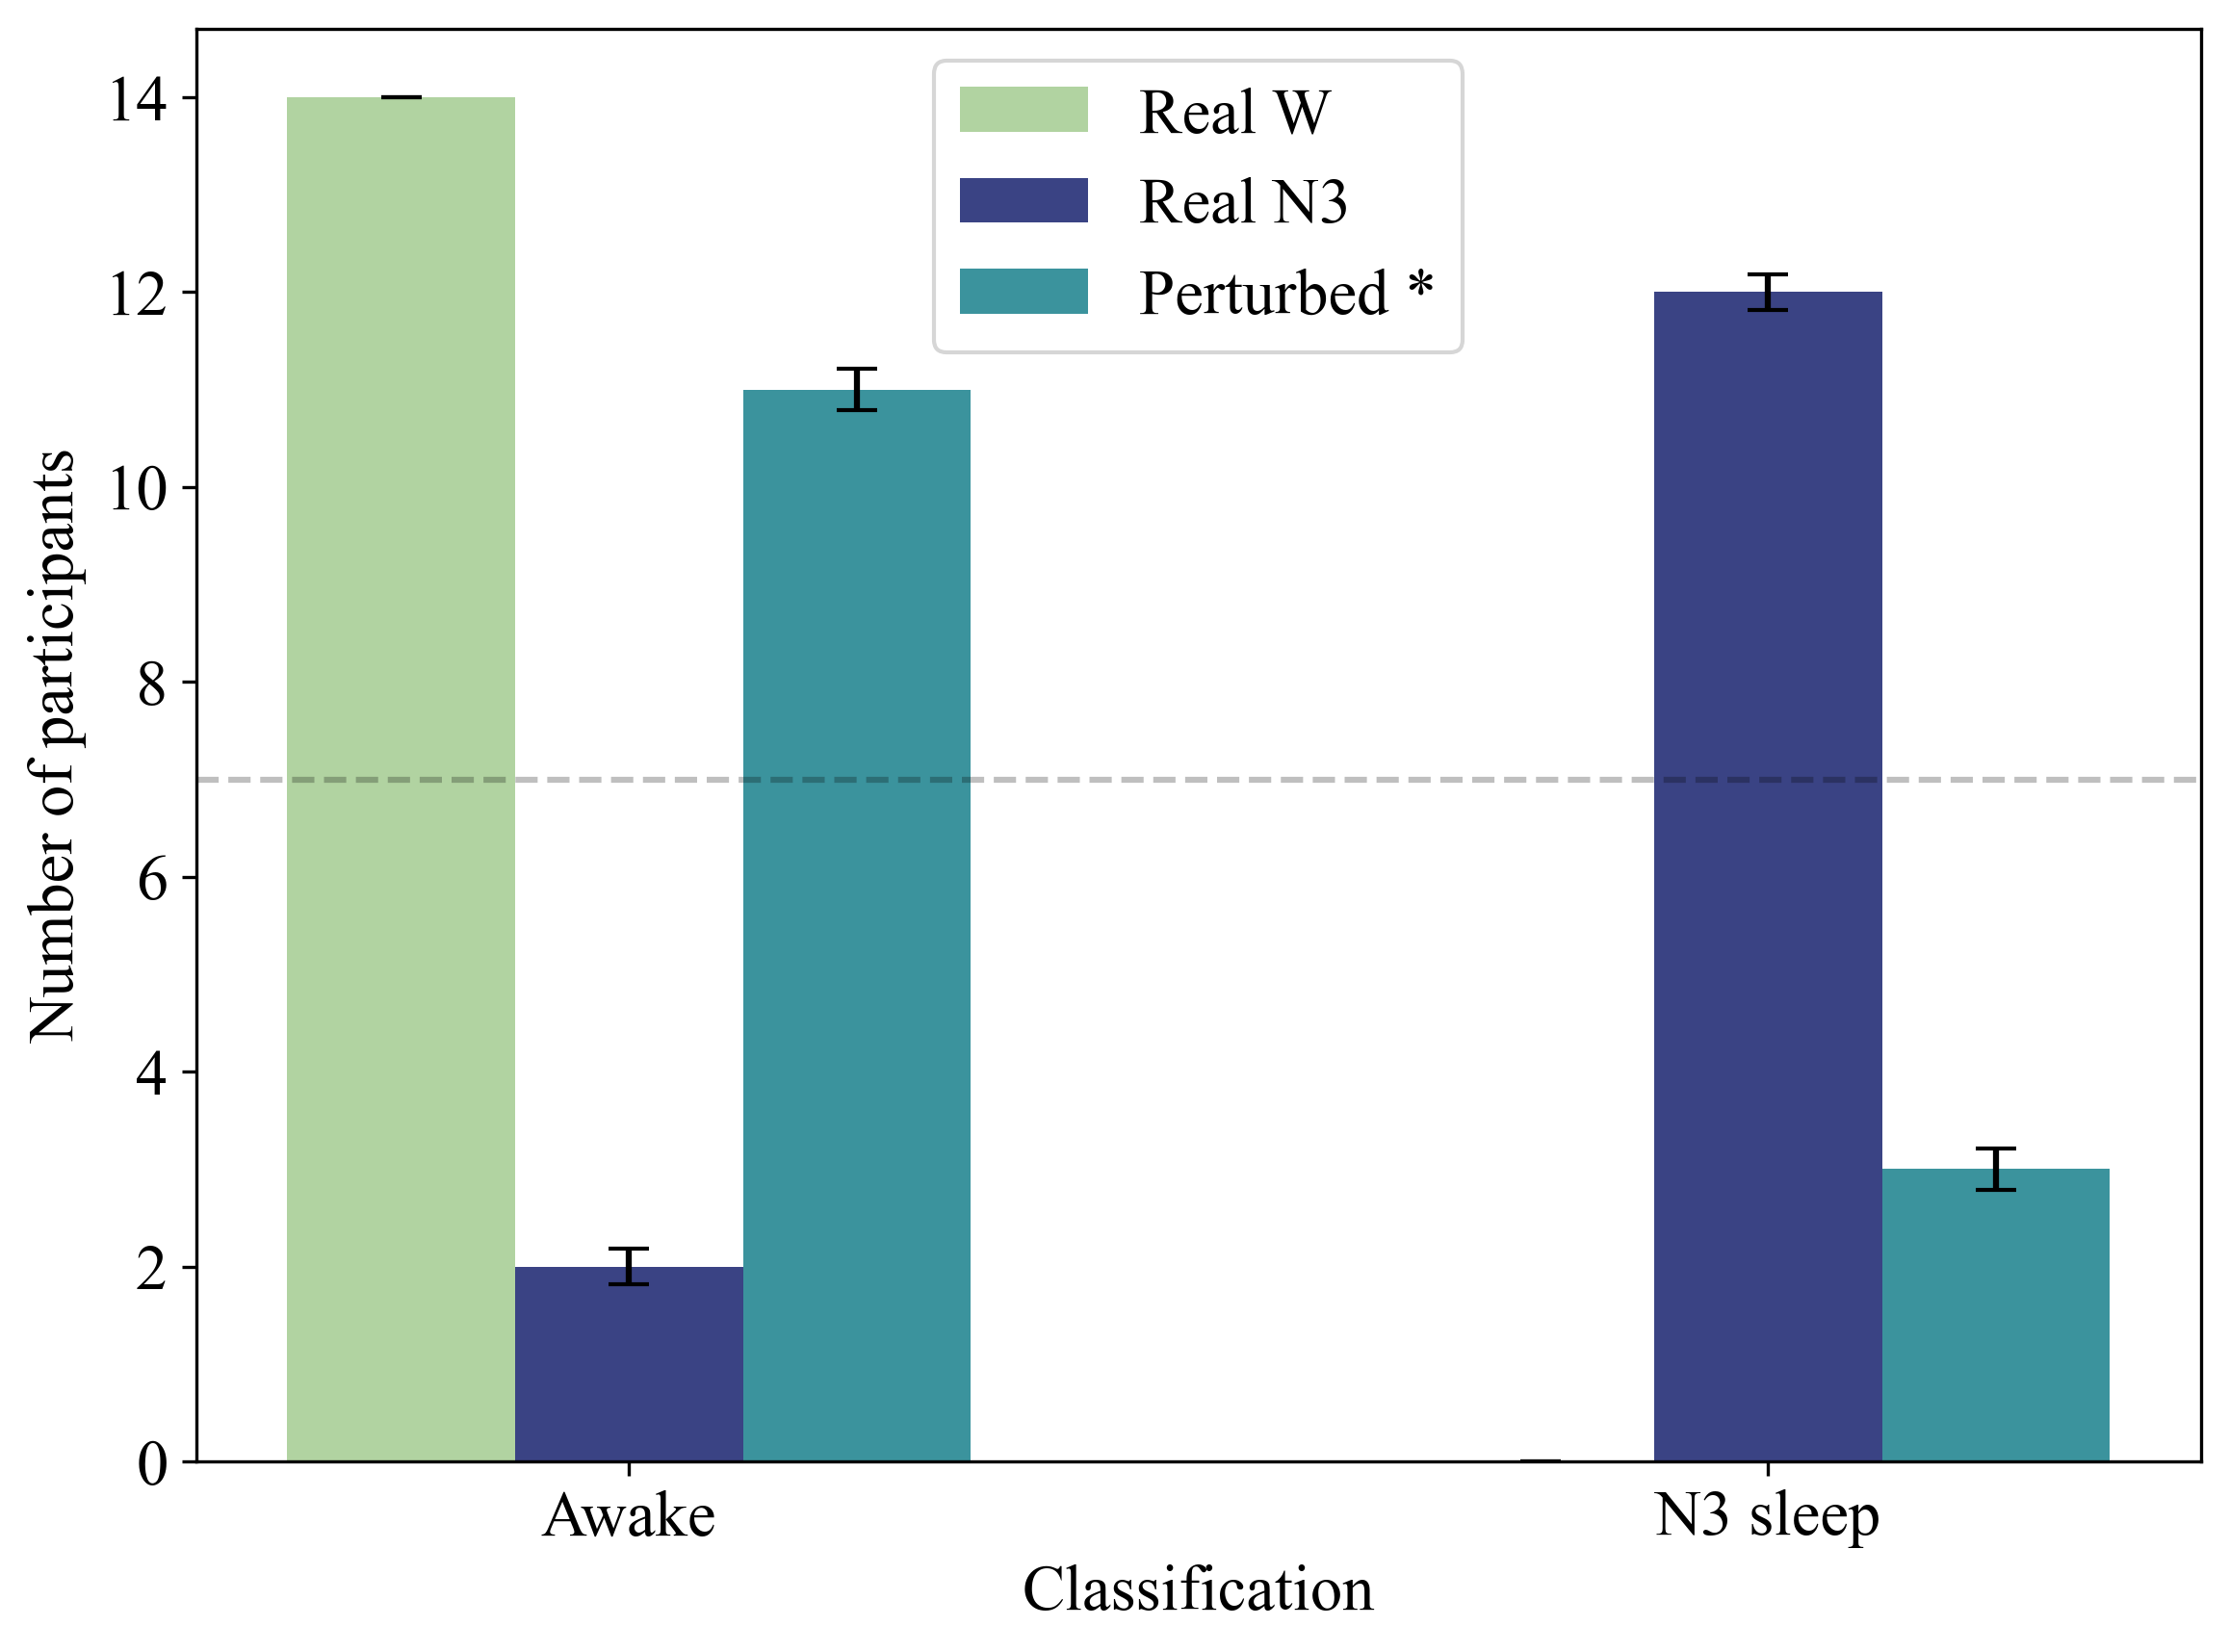

In [25]:
best_signal_region_predictions = total_signals[best_signal][best_region]['Predictions']
best_signal_region_predictions_perturbed = [x[0] for x in best_signal_region_predictions]
best_signal_region_predictions_real_n3 = [x[1] for x in best_signal_region_predictions]
best_signal_region_predictions_real_w = [x[2] for x in best_signal_region_predictions]

# Define the classifications
classifications = [0, 1]

# Count frequencies for each classification
counts_real_w = [best_signal_region_predictions_real_w.count(cls) for cls in classifications]
counts_real_n3 = [best_signal_region_predictions_real_n3.count(cls) for cls in classifications]
counts_perturbed = [best_signal_region_predictions_perturbed.count(cls) for cls in classifications]

# Set the positions and width for the bars
bar_width = 0.2
r1 = np.arange(len(classifications))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Calculate proportions (for illustration)
total_real_w = sum(counts_real_w)
total_real_n3 = sum(counts_real_n3)
total_perturbed = sum(counts_perturbed)

prop_real_w = [count / total_real_w for count in counts_real_w]
prop_real_n3 = [count / total_real_n3 for count in counts_real_n3]
prop_perturbed = [count / total_perturbed for count in counts_perturbed]

# Calculate standard errors (for illustration)
se_real_w = np.sqrt(np.array(prop_real_w) * (1 - np.array(prop_real_w)) / total_real_w)
se_real_n3 = np.sqrt(np.array(prop_real_n3) * (1 - np.array(prop_real_n3)) / total_real_n3)
se_perturbed = np.sqrt(np.array(prop_perturbed) * (1 - np.array(prop_perturbed)) / total_perturbed)

color_real_w = '#B1D3A1'
color_real_n3 = '#3A4384'
color_perturbed = '#3B939D'

# Create the bar plot
plt.figure(figsize=(8, 6))

plt.bar(r1, counts_real_w, width=bar_width, color=color_real_w, label='Real W', yerr=1.95 * se_real_w, capsize=5)
plt.bar(r2, counts_real_n3, width=bar_width, color=color_real_n3, label='Real N3', yerr=1.95 * se_real_n3, capsize=5)
plt.bar(r3, counts_perturbed, width=bar_width, color=color_perturbed, label='Perturbed *', yerr=1.95 * se_perturbed, capsize=5)

# Add labels
# plt.title('Single region perturbation classification')
plt.xlabel('Classification')
plt.ylabel('Number of participants')
plt.xticks([r + bar_width for r in range(len(classifications))], ['Awake', 'N3 sleep'])
plt.axhline(y=num_n3//2, color='black', linestyle='--', alpha=0.25)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

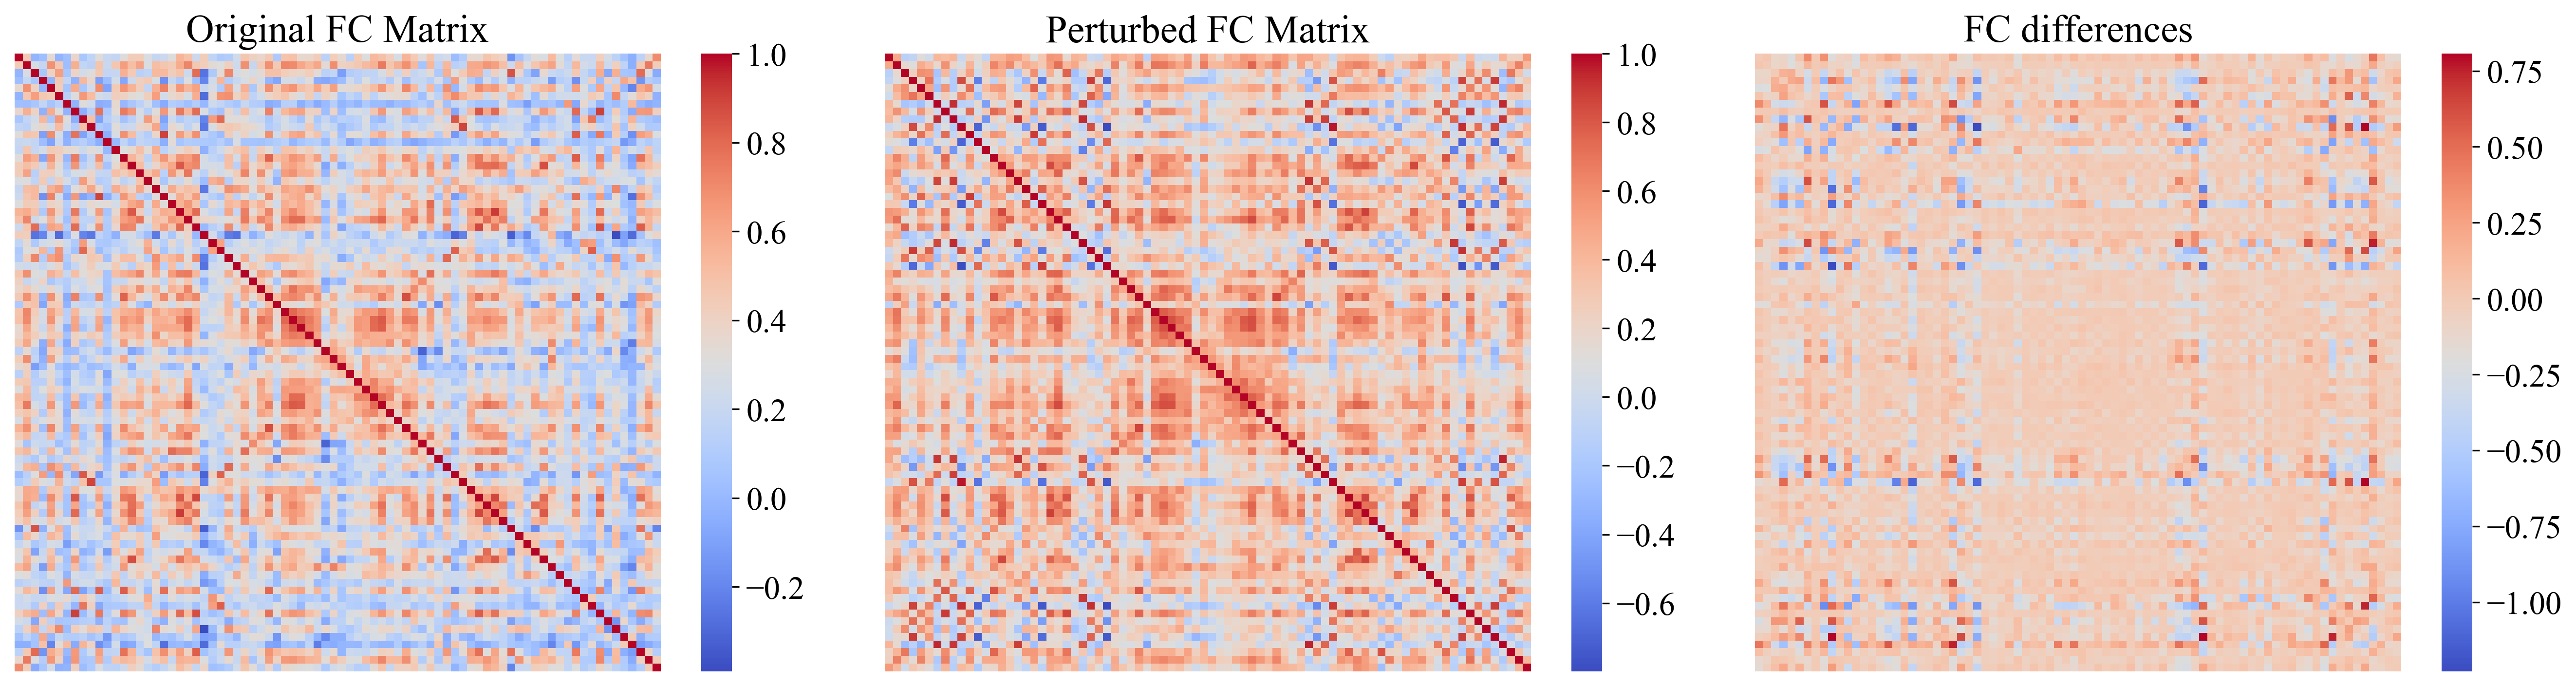

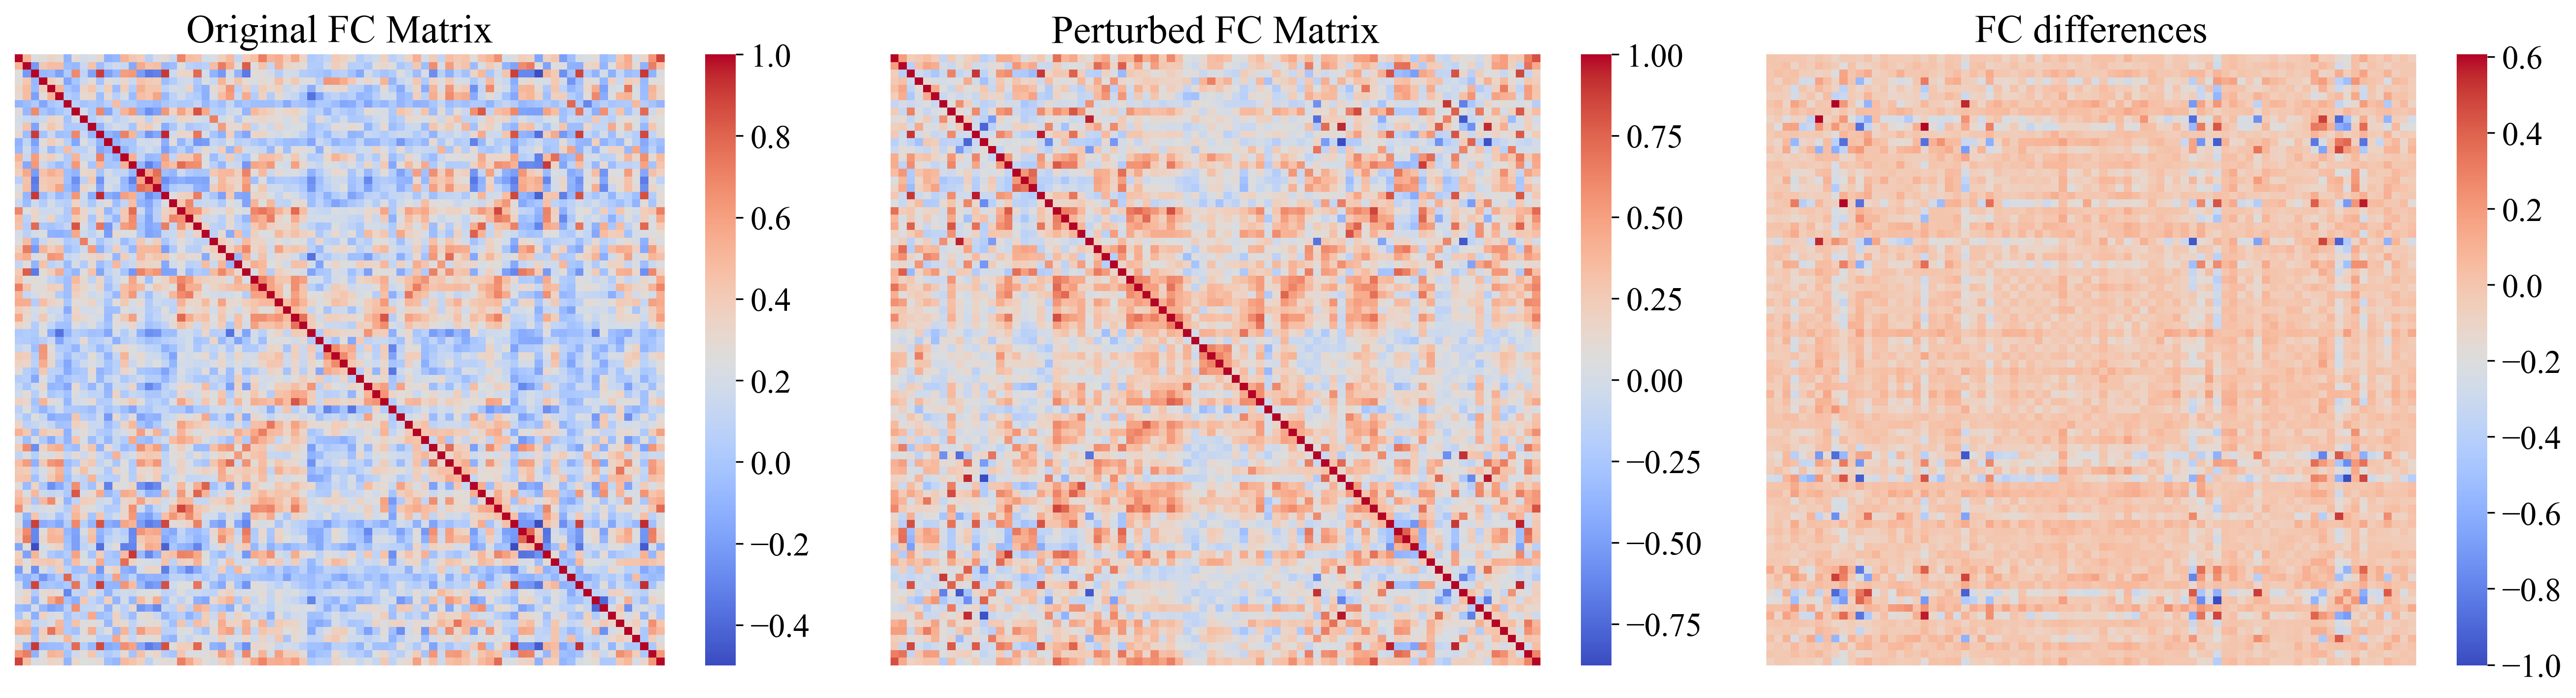

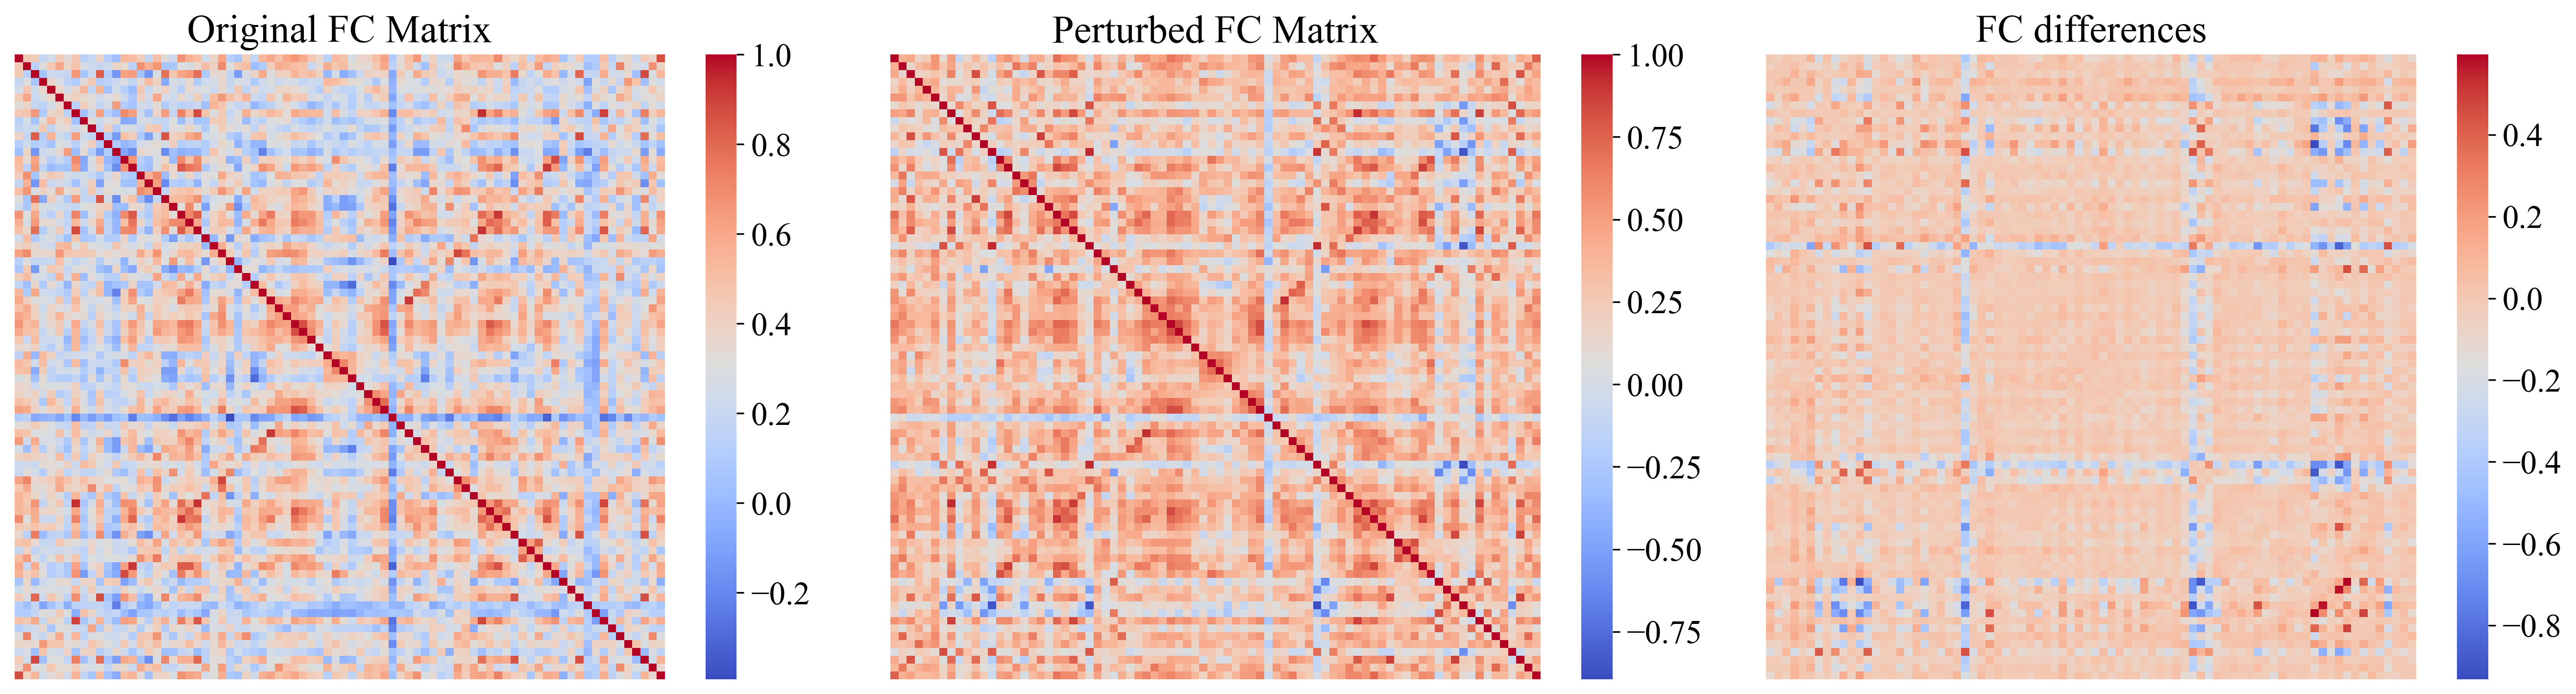

In [29]:
# perform best signal and region and plot FC matrices
region = int(best_region) - 1

for participant in range(num_n3//4):
    sleeper = latent_n3_data[participant]
    perturbed_data = apply_perturbation_one_region(sleeper, signals[best_signal], region)
    decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
    decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
    decoded_original = model.decoder(sleeper.view(-1, latent_dimension))
    decoded_fc_original = compute_fc_matrix_regular(decoded_original.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
    decoded_awake = model.decoder(latent_wake_data[participant].view(-1, latent_dimension))
    decoded_fc_awake = compute_fc_matrix_regular(decoded_awake.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

    fc_diff = decoded_fc - decoded_fc_original

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(decoded_fc_original, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('Original FC Matrix')
    plt.subplot(1, 3, 2)
    sns.heatmap(decoded_fc, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('Perturbed FC Matrix')
    plt.subplot(1, 3, 3)
    sns.heatmap(fc_diff, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('FC differences')
    # plt.subplot(1, 4, 4)
    # sns.heatmap(decoded_fc_awake, cmap="coolwarm", xticklabels=False, yticklabels=False)
    # plt.title('Awake FC Matrix')
    # plt.show()
    plt.tight_layout()

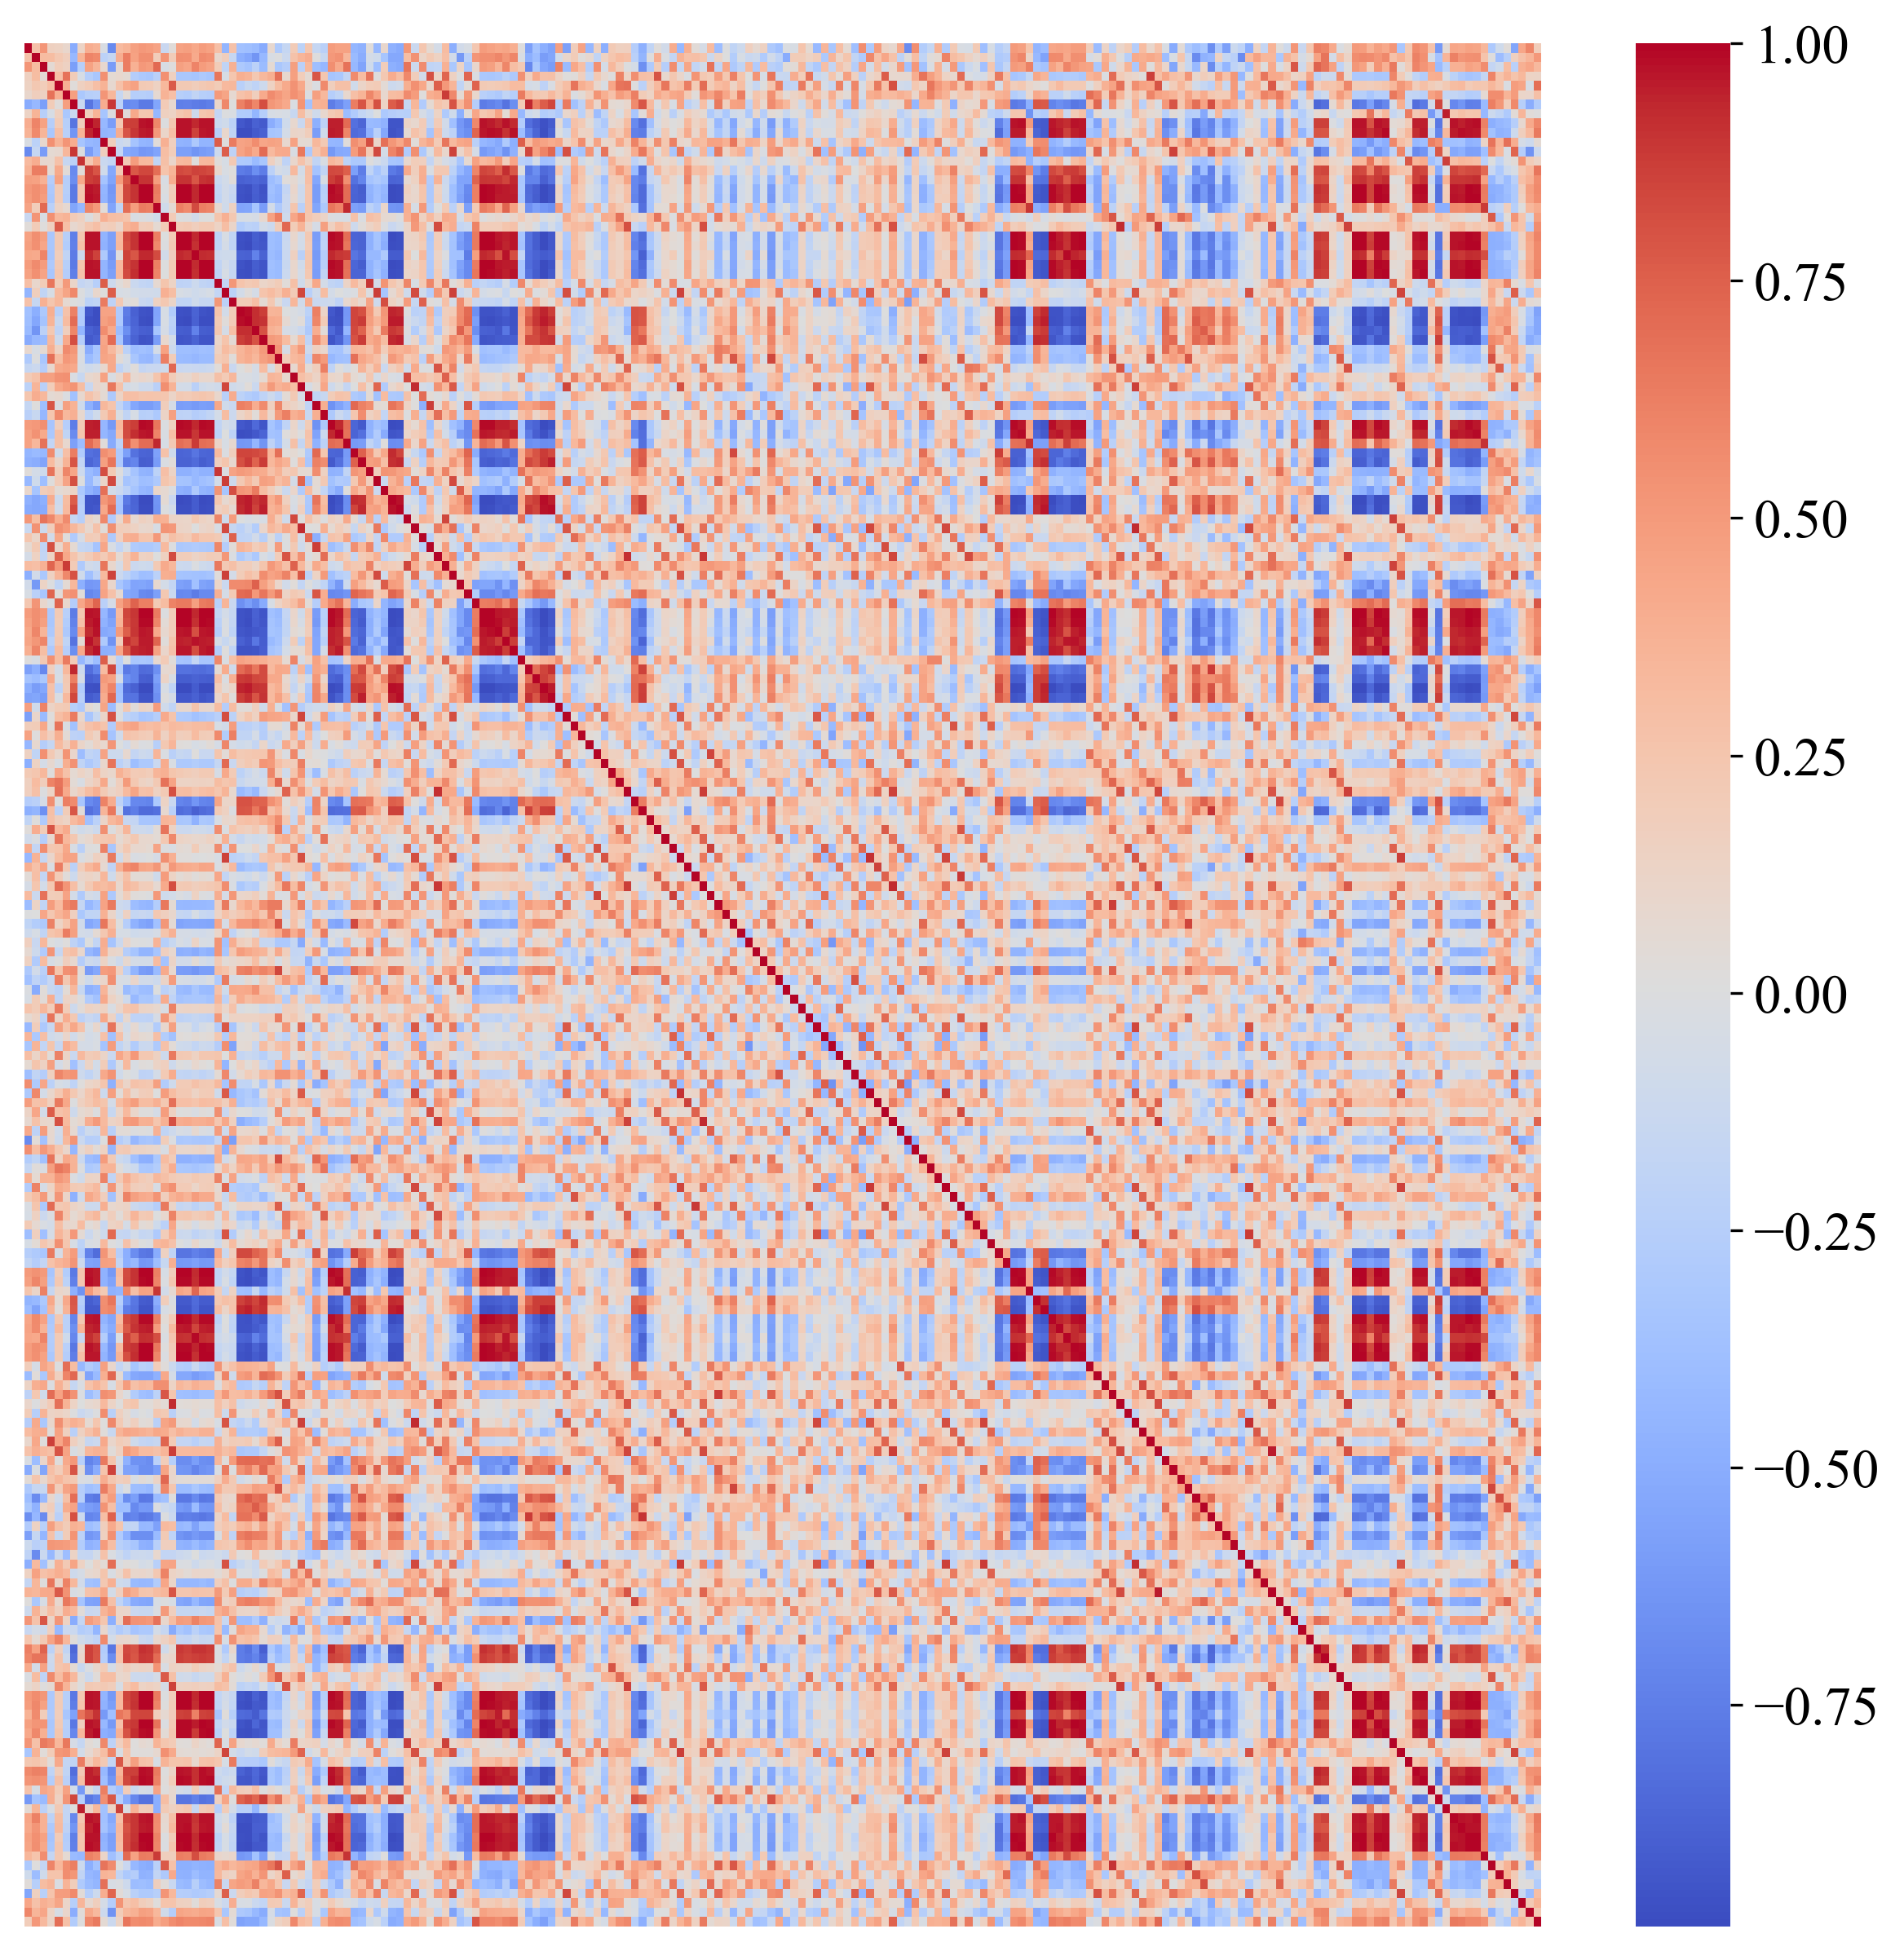

In [34]:
# plot the average correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(np.corrcoef(latent_n3_data[0]), xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()

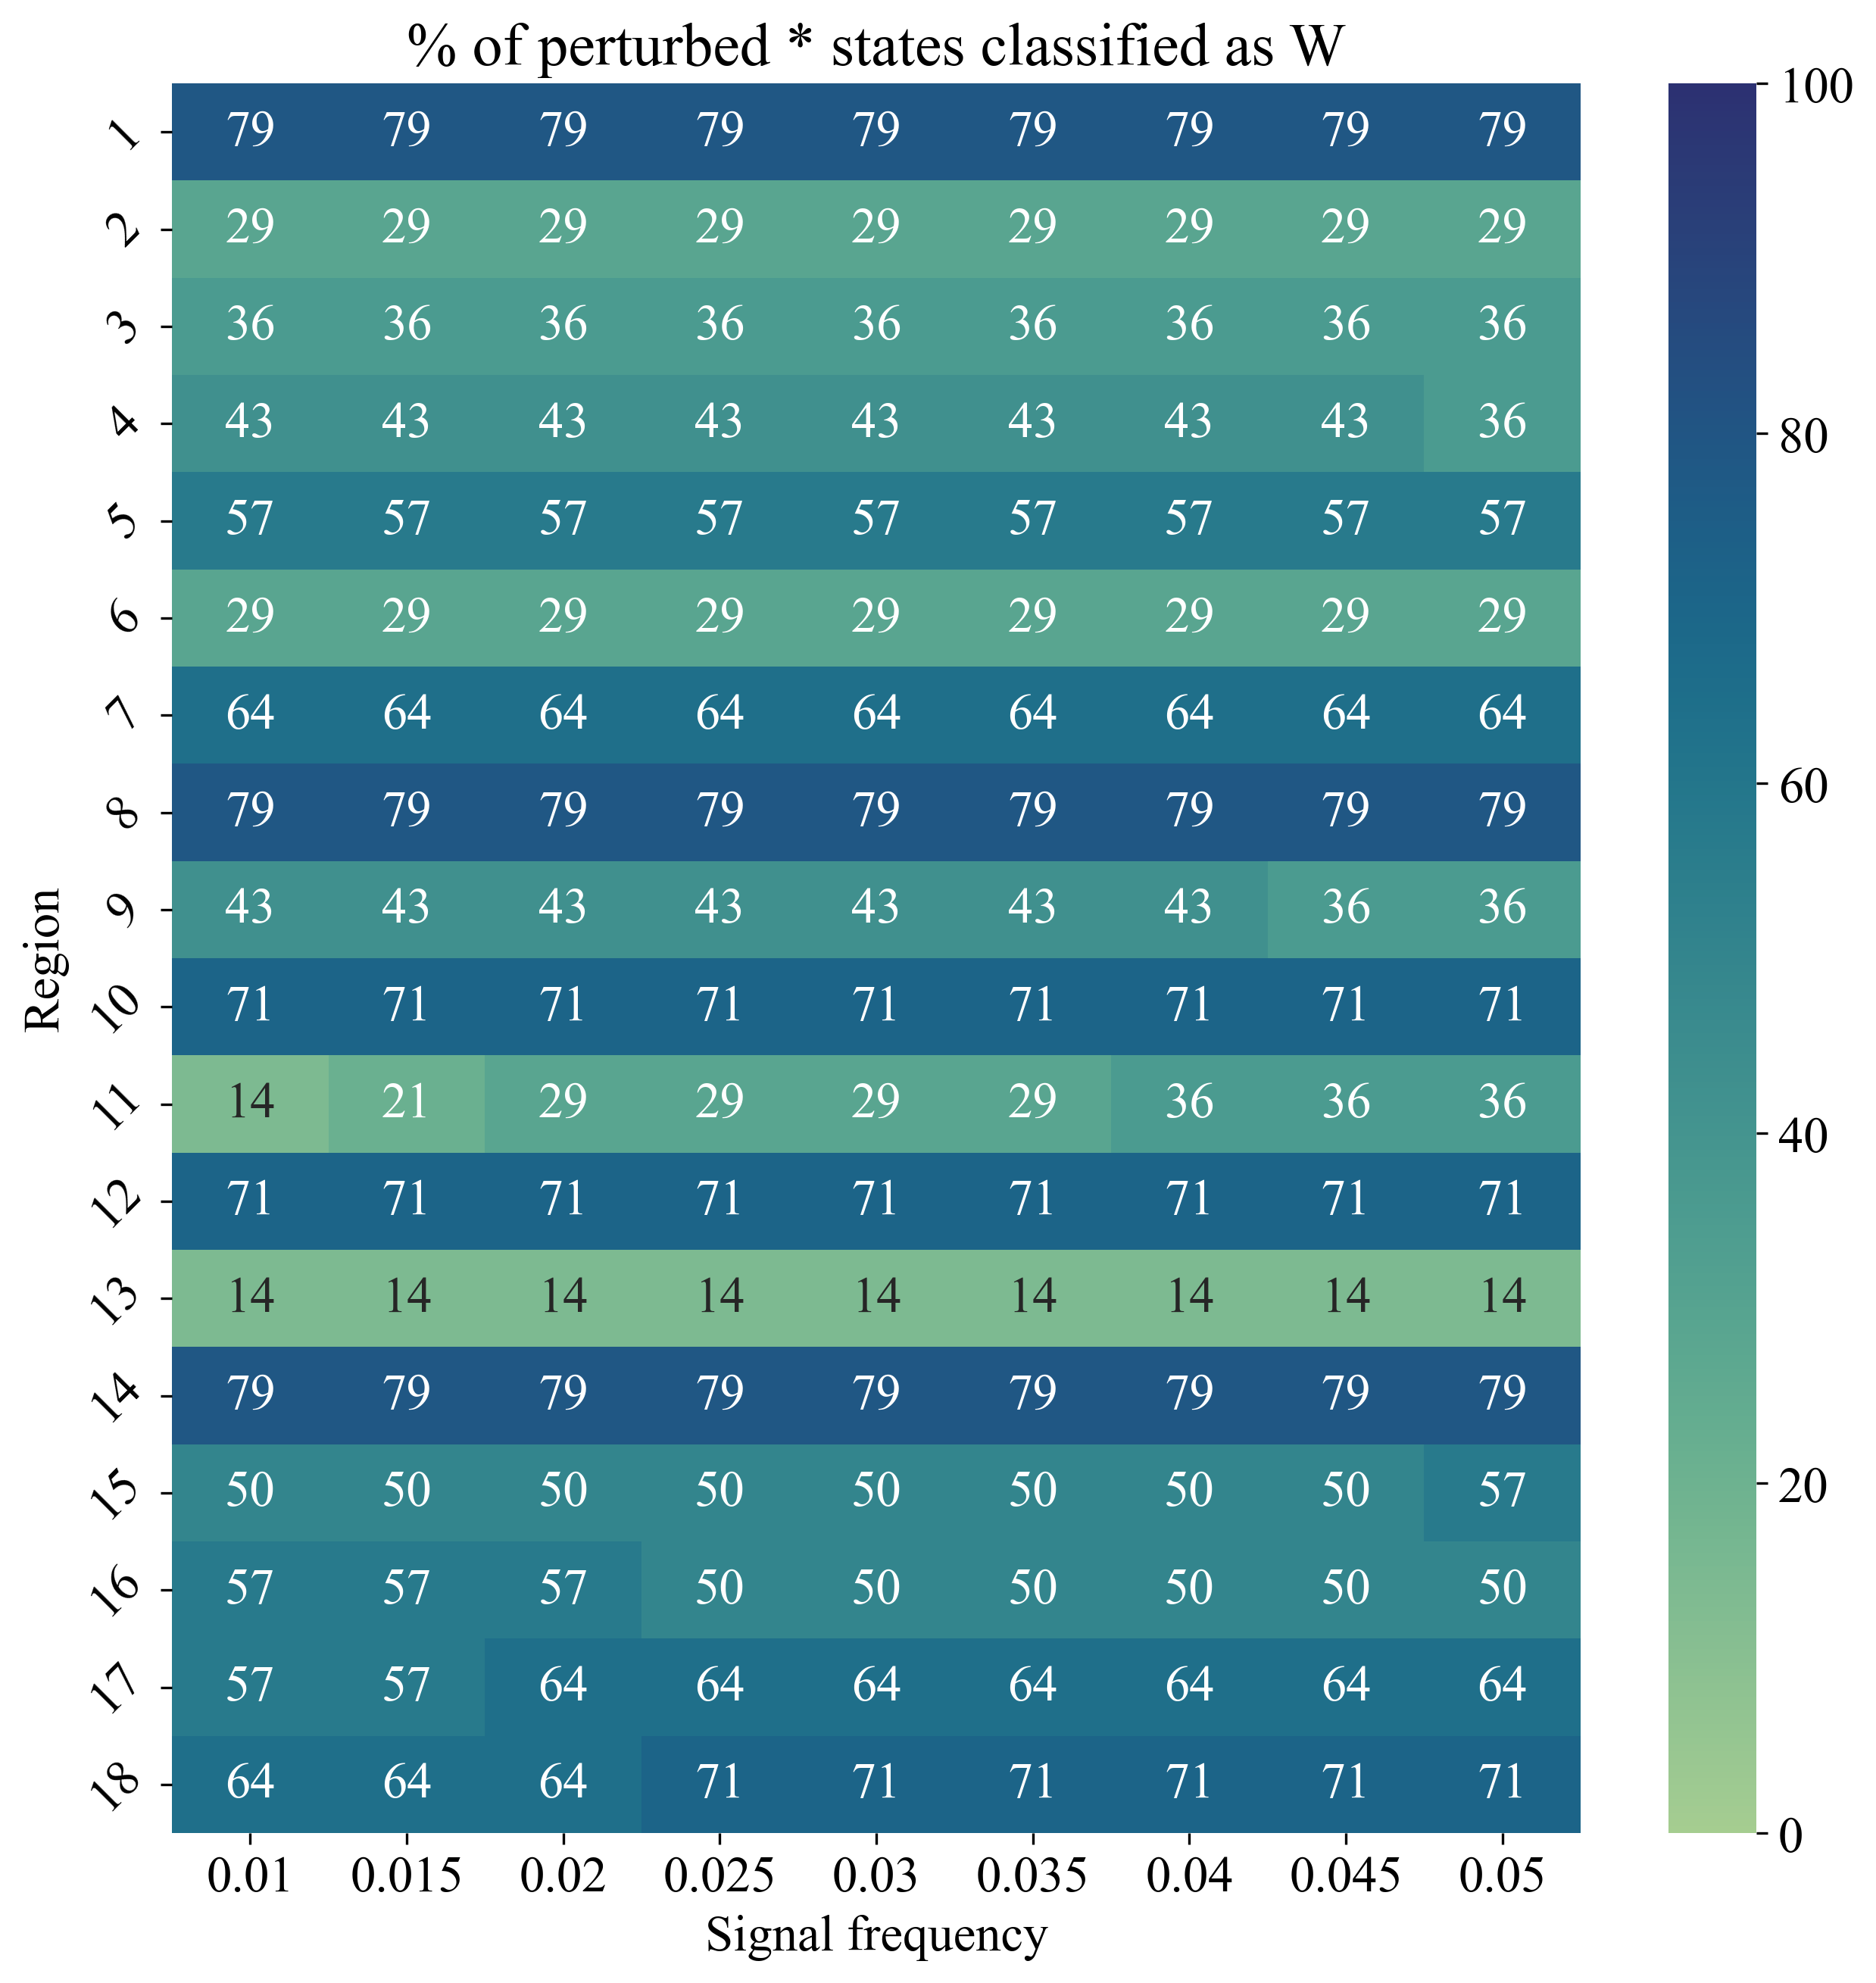

In [281]:
# extract probabilities for each region and frequency combination
probabilities = np.zeros((latent_dimension, len(freqs)))

x_axis = freqs
y_axis = total_regions.keys()

for key, regions in total_signals.items():
    for region, data in regions.items():
        region_number = int(region) - 1
        frequency = re.findall(r'\d+', key)
        frequency = '.'.join(frequency)

        # % of perturbed* states classified as W
        prob = sum(1 for p in data['Predictions'] if p[0] == 0) / num_n3 * 100

        # mean probability of perturbed* states classified as W
        # prob = np.mean([x[0][0] for x in data['Probabilities']])

        # mean probability of perturbed* states classified as W for participant 5
        # prob = np.mean([x[0][0] for x in data['Probabilities'][5:6]])

        probabilities[region_number, freqs.index(float(frequency))] = prob

plt.figure(figsize=(10, 10))
sns.heatmap(probabilities, cmap="crest", xticklabels=x_axis, yticklabels=y_axis, annot=True, vmin=0, vmax=100)
plt.title('% of perturbed * states classified as W')
plt.xlabel('Signal frequency')
plt.ylabel('Region')
plt.yticks(rotation=45)
plt.show()

### DOUBLE REGION PERTURBATION

In [282]:
total_signals = {key: {} for key in signals.keys()}
total_regions = {}

for key, signal in signals.items():
    for region in range(latent_dimension):
        for region_two in range(region + 1, latent_dimension):  # Iterate only over region_two > region

            region_name = f"{region + 1}+{region_two + 1}"
            
            count_awake_after = {f"{region_name}": 0}
            count_n3_after = {f"{region_name}": 0}

            predictions = []
            predictions_proba = []
            participant_signals = []
            amplitudes = []

            for participant in range(num_n3):
                latent_region_std_participant = torch.std(latent_n3_data[participant, region])
                latent_region_std_participant_two = torch.std(latent_n3_data[participant, region_two])

                full_signal = signal * latent_region_std_participant
                full_signal_two = signal * latent_region_std_participant_two

                perturbed_data = apply_perturbation_two_region(latent_n3_data[participant], 
                                                                full_signal, region,
                                                                full_signal_two, region_two)

                decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
                decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

                perturbed_lower_triangle = utils.extract_lower_triangle(decoded_fc)
                n3_lower_triangle = utils.extract_lower_triangle(n3_participants_fcs[participant])
                awake_lower_triangle = utils.extract_lower_triangle(awake_participants_fcs[participant])

                pred = classifier_reconstructed.predict([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])
                pred_prob = classifier_reconstructed.predict_proba([perturbed_lower_triangle, n3_lower_triangle, awake_lower_triangle])

                predictions.append(pred)
                predictions_proba.append(pred_prob)
                participant_signals.append((full_signal, full_signal_two))
                amplitudes.append((latent_region_std_participant, latent_region_std_participant_two))

                if pred[0] == 0:  # Classifying as awake
                    count_awake_after[f"{region + 1}+{region_two + 1}"] += 1
                else:  # Classifying as N3
                    count_n3_after[f"{region + 1}+{region_two + 1}"] += 1

            total_regions.setdefault(region_name, {
                'Predictions': [],
                'Probabilities': [],
                'Amplitude': [],
                'Signals': [],
                'Count Awake': count_awake_after,
                'Count N3': count_n3_after
            })

            total_regions[region_name]['Predictions'].extend(predictions)
            total_regions[region_name]['Probabilities'].extend(predictions_proba)
            total_regions[region_name]['Amplitude'].extend(amplitudes)
            total_regions[region_name]['Signals'].extend(participant_signals)
            total_regions[region_name]['Count Awake'] = count_awake_after
            total_regions[region_name]['Count N3'] = count_n3_after

            awake_perturbed_count = sum(1 for p in predictions if p[0] == 0)
            percentage_awake = awake_perturbed_count / num_n3 * 100

            total_signals[key][region_name] = {
                'Percentage': percentage_awake,
                'Predictions': predictions,
                'Probabilities': predictions_proba,
                'Amplitude': amplitudes,
                'Signals': participant_signals,
                'Count Awake': count_awake_after,
                'Count N3': count_n3_after
            }

In [283]:
# Chi squared test for each region combination
for key, regions in total_signals.items():
    print (f"Signal {key}")
    for region, data in regions.items():
        count_awake_before = np.sum([classifier_reconstructed.predict([utils.extract_lower_triangle(n3_participants_fcs[participant])])[0] == 0 for participant in range(num_n3)])
        count_n3_before = num_n3 - count_awake_before

        count_awake_after = data['Count Awake']
        count_n3_after = data['Count N3']

        before = np.array([[count_awake_before, count_n3_before]])
        after = np.array([[count_awake_after[f"{region}"], count_n3_after[f"{region}"]]])
        chi2, p, _, _ = chi2_contingency(np.concatenate([before, after], axis=0))

        print (f"Region {region}, Chi2: {chi2:.2f}, p-value: {p:.2f}, significant: {p < 0.05}")

Signal f0.01
Region 1+2, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+3, Chi2: 9.19, p-value: 0.00, significant: True
Region 1+4, Chi2: 9.19, p-value: 0.00, significant: True
Region 1+5, Chi2: 9.19, p-value: 0.00, significant: True
Region 1+6, Chi2: 9.19, p-value: 0.00, significant: True
Region 1+7, Chi2: 7.15, p-value: 0.01, significant: True
Region 1+8, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+9, Chi2: 7.15, p-value: 0.01, significant: True
Region 1+10, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+11, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+12, Chi2: 7.15, p-value: 0.01, significant: True
Region 1+13, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+14, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+15, Chi2: 14.36, p-value: 0.00, significant: True
Region 1+16, Chi2: 11.57, p-value: 0.00, significant: True
Region 1+17, Chi2: 9.19, p-value: 0.00, significant: True
Region 1+18, Chi2: 11.57, p-value: 0.00, significant: True


In [284]:
# Find the region and signal with the highest percentage
best_percentage = 0
best_probabilities = None
best_signal = None
best_region = None
best_amplitude = None
best_signals = None

for key, regions in total_signals.items():
    for region, data in regions.items():
        percentage = data['Percentage']
        probabilities = data['Probabilities']
        amplitude = data['Amplitude']
        participant_signals = data['Signals']
        participant_amplitudes = data['Amplitude']
        
        print(f"Signal: {key}, Region: {region}, Percentage: {percentage}")

        if percentage > best_percentage:
            best_percentage = percentage
            best_probabilities = probabilities
            best_signal = key
            best_region = region
            best_amplitude = participant_amplitudes
            best_signals = participant_signals

print(f"\nBest combination: Signal {best_signal}, Region {best_region}, Percentage {best_percentage}")

Signal: f0.01, Region: 1+2, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+3, Percentage: 78.57142857142857
Signal: f0.01, Region: 1+4, Percentage: 78.57142857142857
Signal: f0.01, Region: 1+5, Percentage: 78.57142857142857
Signal: f0.01, Region: 1+6, Percentage: 78.57142857142857
Signal: f0.01, Region: 1+7, Percentage: 71.42857142857143
Signal: f0.01, Region: 1+8, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+9, Percentage: 71.42857142857143
Signal: f0.01, Region: 1+10, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+11, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+12, Percentage: 71.42857142857143
Signal: f0.01, Region: 1+13, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+14, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+15, Percentage: 92.85714285714286
Signal: f0.01, Region: 1+16, Percentage: 85.71428571428571
Signal: f0.01, Region: 1+17, Percentage: 78.57142857142857
Signal: f0.01, Region: 1+18, Percentage: 85.71428571428571
Signa

In [285]:
best_signal, best_region, best_percentage

('f0.01', '1+15', 92.85714285714286)

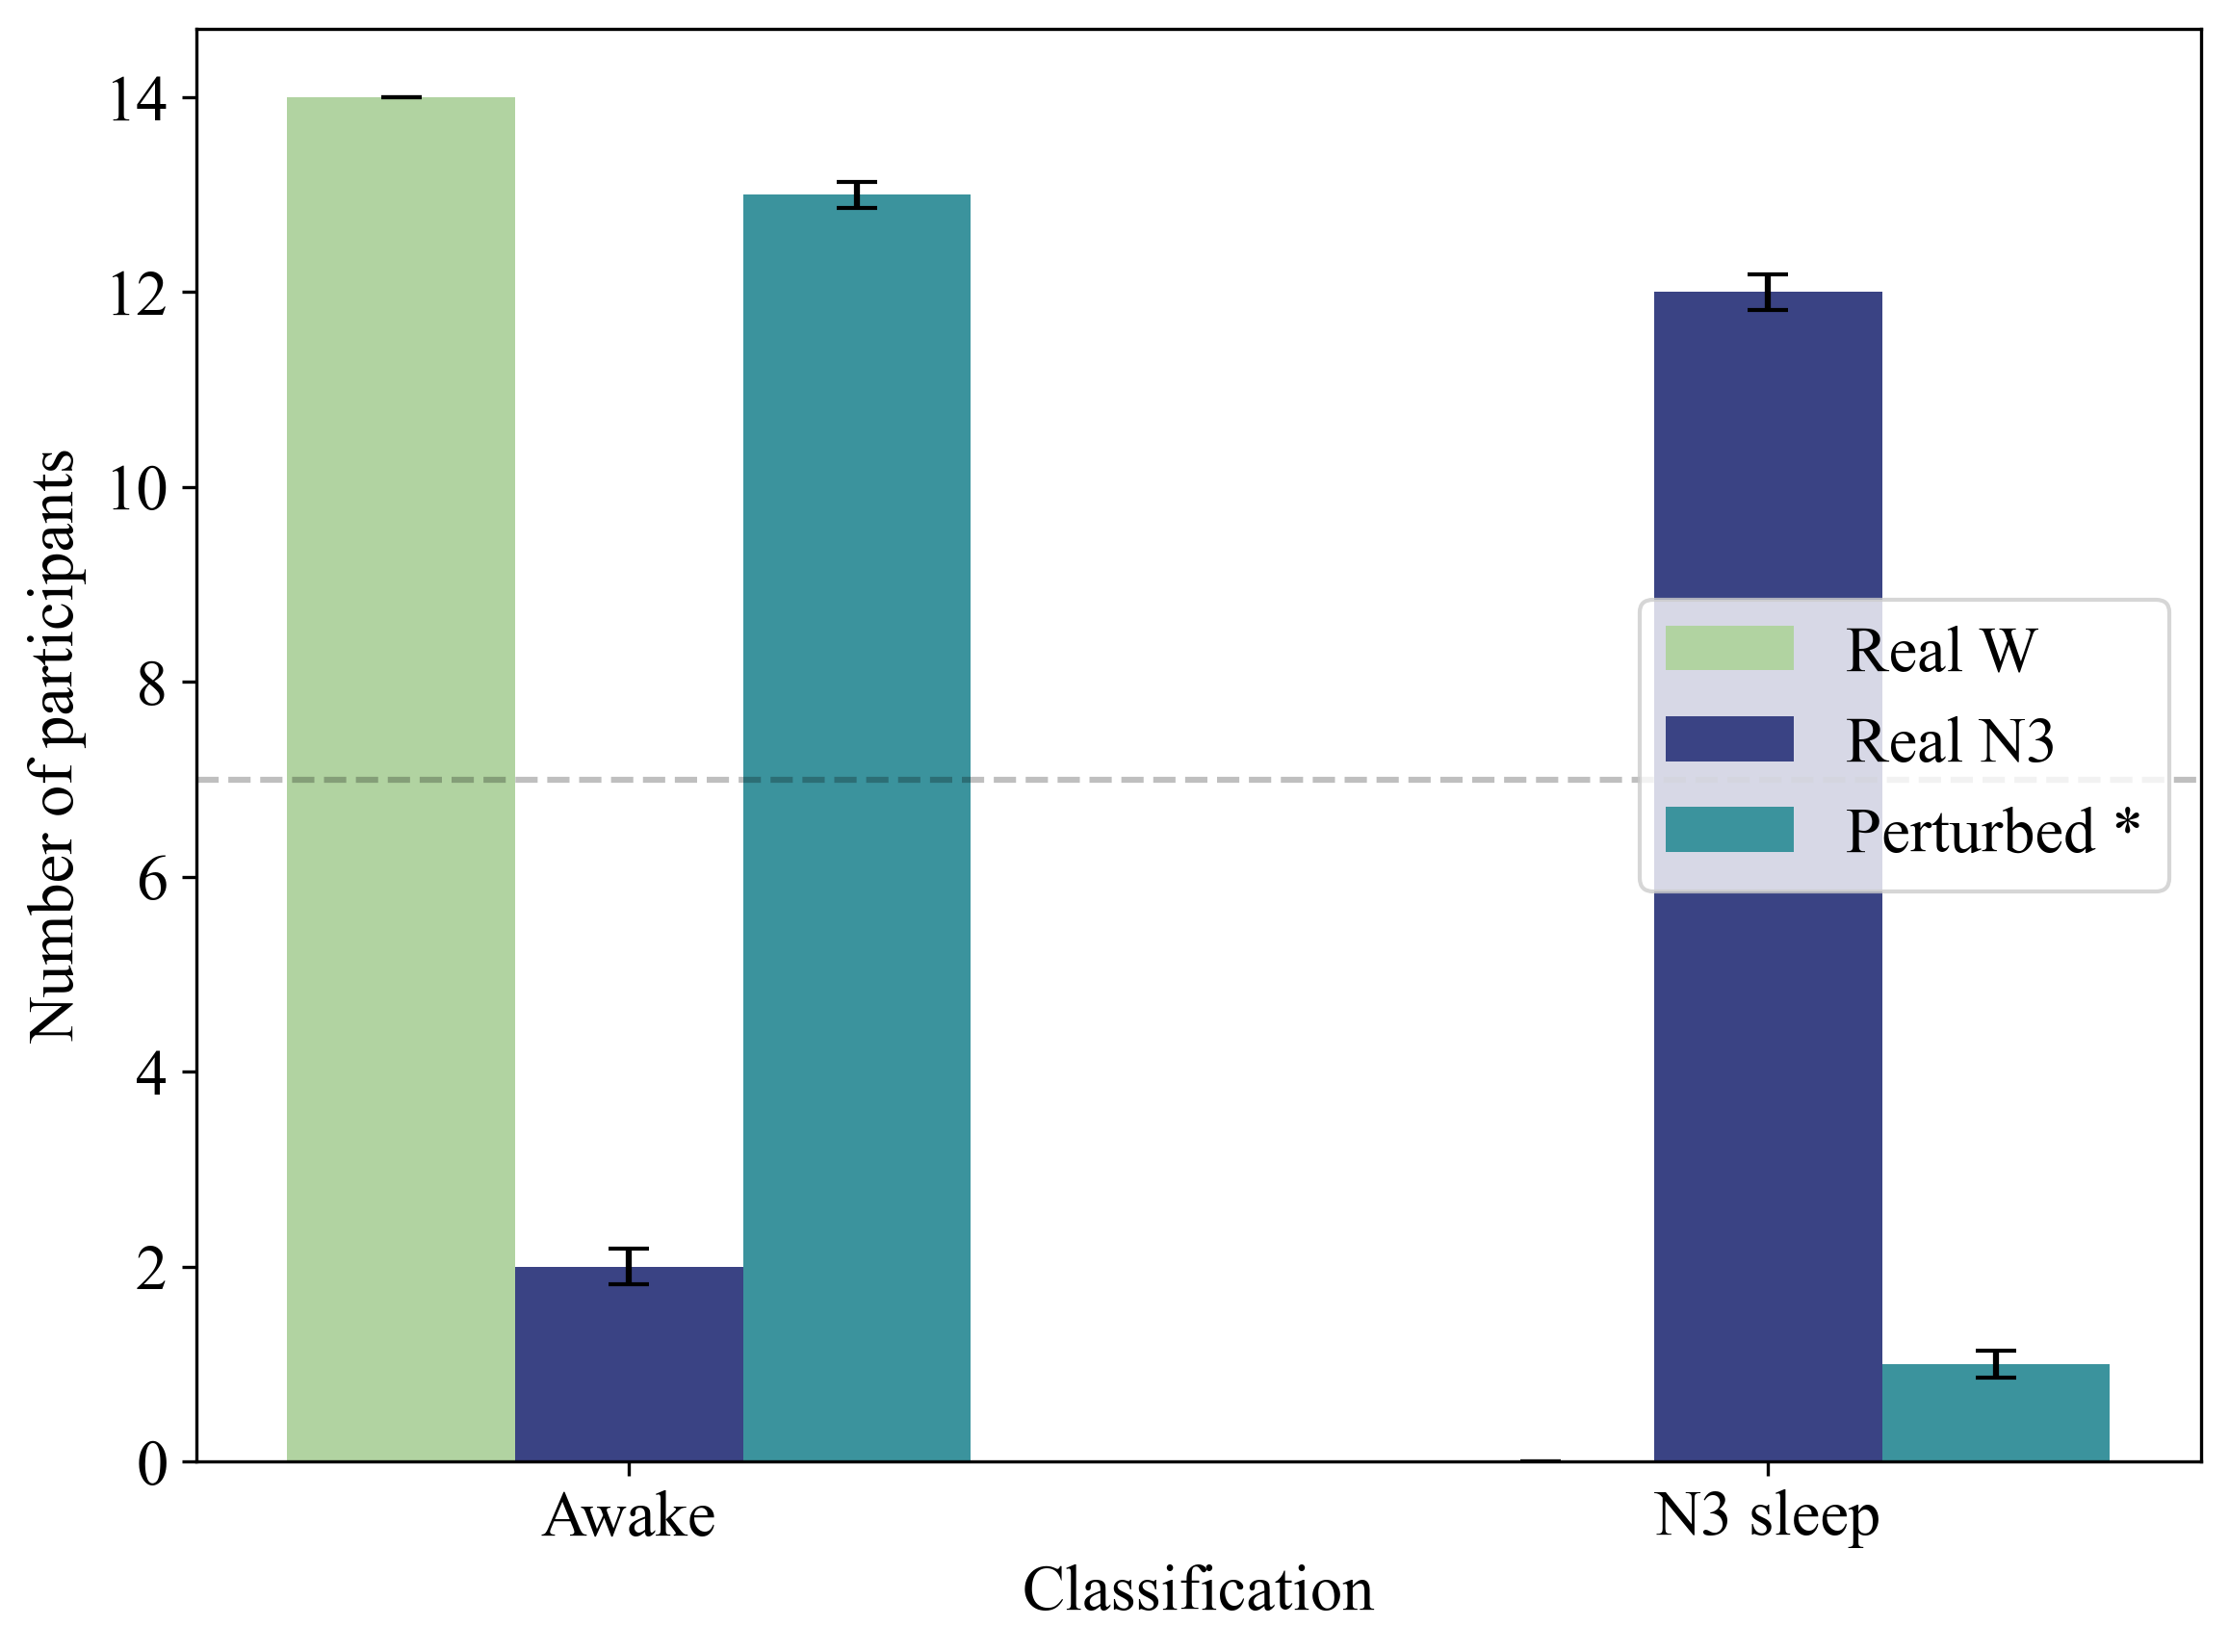

In [286]:
best_signal_region_predictions = total_signals[best_signal][best_region]['Predictions']
best_signal_region_predictions_perturbed = [x[0] for x in best_signal_region_predictions]
best_signal_region_predictions_real_n3 = [x[1] for x in best_signal_region_predictions]
best_signal_region_predictions_real_w = [x[2] for x in best_signal_region_predictions]

# Define the classifications
classifications = [0, 1]

# Count frequencies for each classification
counts_real_w = [best_signal_region_predictions_real_w.count(cls) for cls in classifications]
counts_real_n3 = [best_signal_region_predictions_real_n3.count(cls) for cls in classifications]
counts_perturbed = [best_signal_region_predictions_perturbed.count(cls) for cls in classifications]

# Set the positions and width for the bars
bar_width = 0.2
r1 = np.arange(len(classifications))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Calculate proportions (for illustration)
total_real_w = sum(counts_real_w)
total_real_n3 = sum(counts_real_n3)
total_perturbed = sum(counts_perturbed)

prop_real_w = [count / total_real_w for count in counts_real_w]
prop_real_n3 = [count / total_real_n3 for count in counts_real_n3]
prop_perturbed = [count / total_perturbed for count in counts_perturbed]

# Calculate standard errors (for illustration)
se_real_w = np.sqrt(np.array(prop_real_w) * (1 - np.array(prop_real_w)) / total_real_w)
se_real_n3 = np.sqrt(np.array(prop_real_n3) * (1 - np.array(prop_real_n3)) / total_real_n3)
se_perturbed = np.sqrt(np.array(prop_perturbed) * (1 - np.array(prop_perturbed)) / total_perturbed)

color_real_w = '#B1D3A1'
color_real_n3 = '#3A4384'
color_perturbed = '#3B939D'

# Create the bar plot
plt.figure(figsize=(8, 6))

plt.bar(r1, counts_real_w, width=bar_width, color=color_real_w, label='Real W', yerr=1.95 * se_real_w, capsize=5)
plt.bar(r2, counts_real_n3, width=bar_width, color=color_real_n3, label='Real N3', yerr=1.95 * se_real_n3, capsize=5)
plt.bar(r3, counts_perturbed, width=bar_width, color=color_perturbed, label='Perturbed *', yerr=1.95 * se_perturbed, capsize=5)

# Add labels
# plt.title('Double region perturbation classification')
plt.xlabel('Classification')
plt.ylabel('Number of participants')
plt.xticks([r + bar_width for r in range(len(classifications))], ['Awake', 'N3 sleep'])
plt.axhline(y=num_n3//2, color='black', linestyle='--', alpha=0.25)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

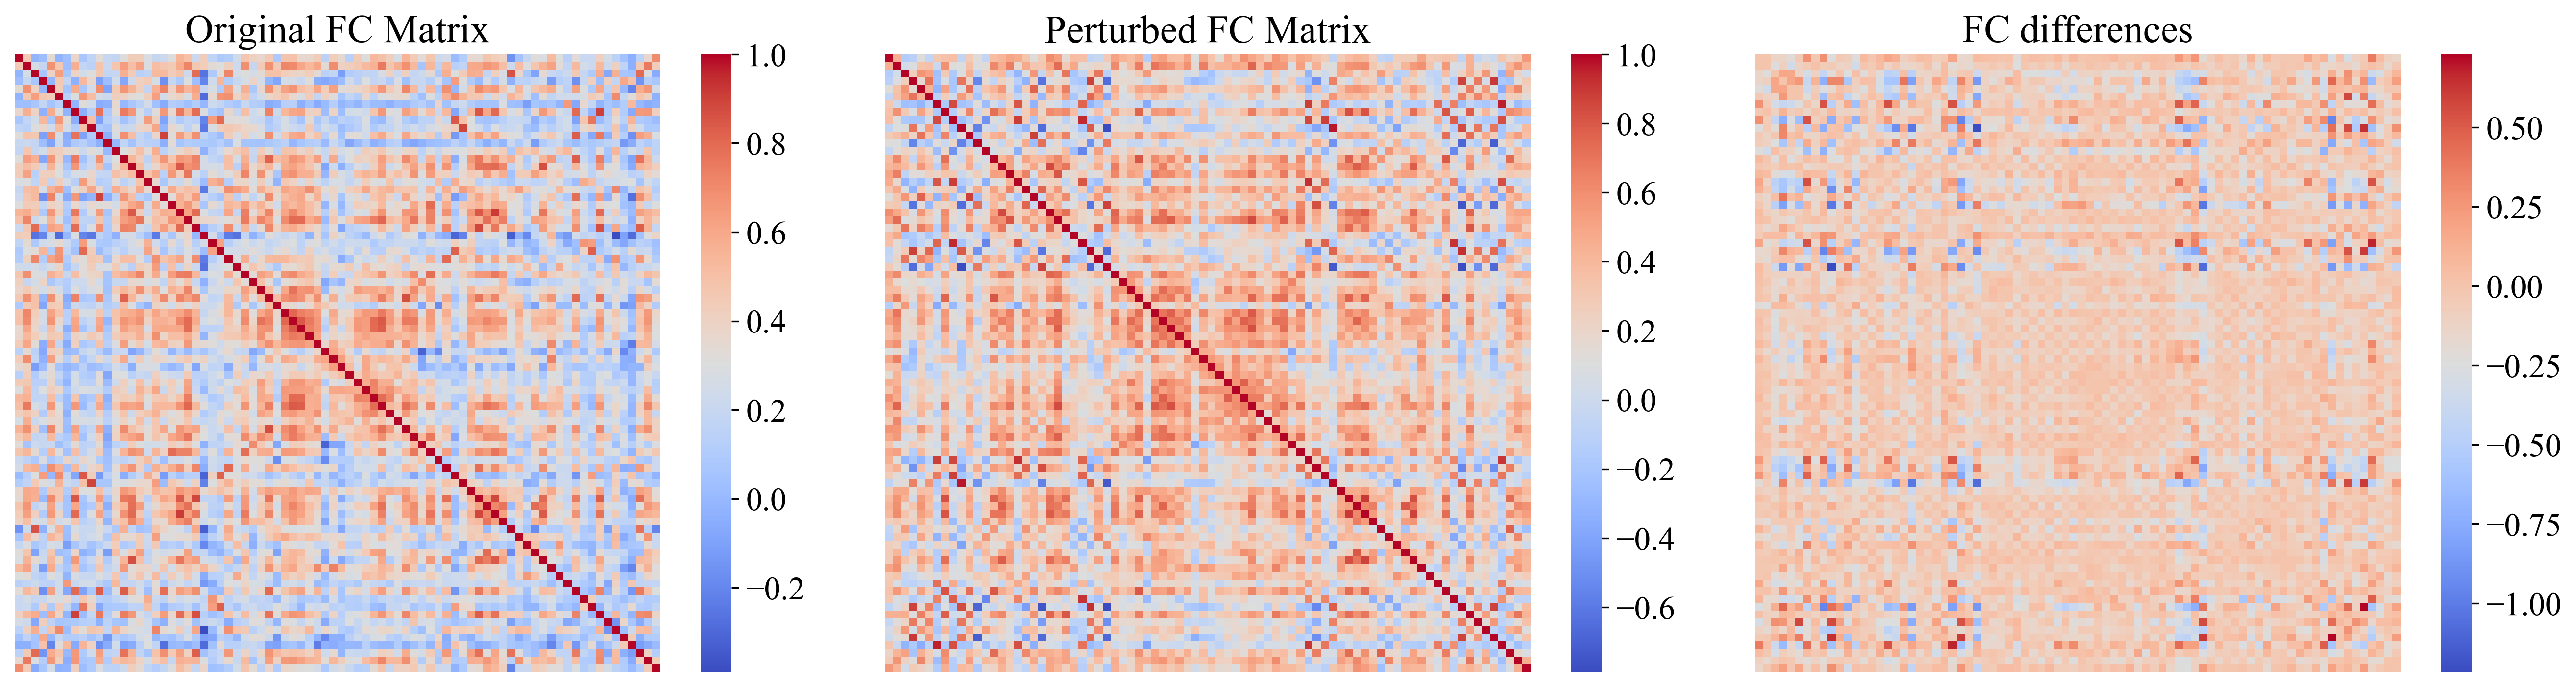

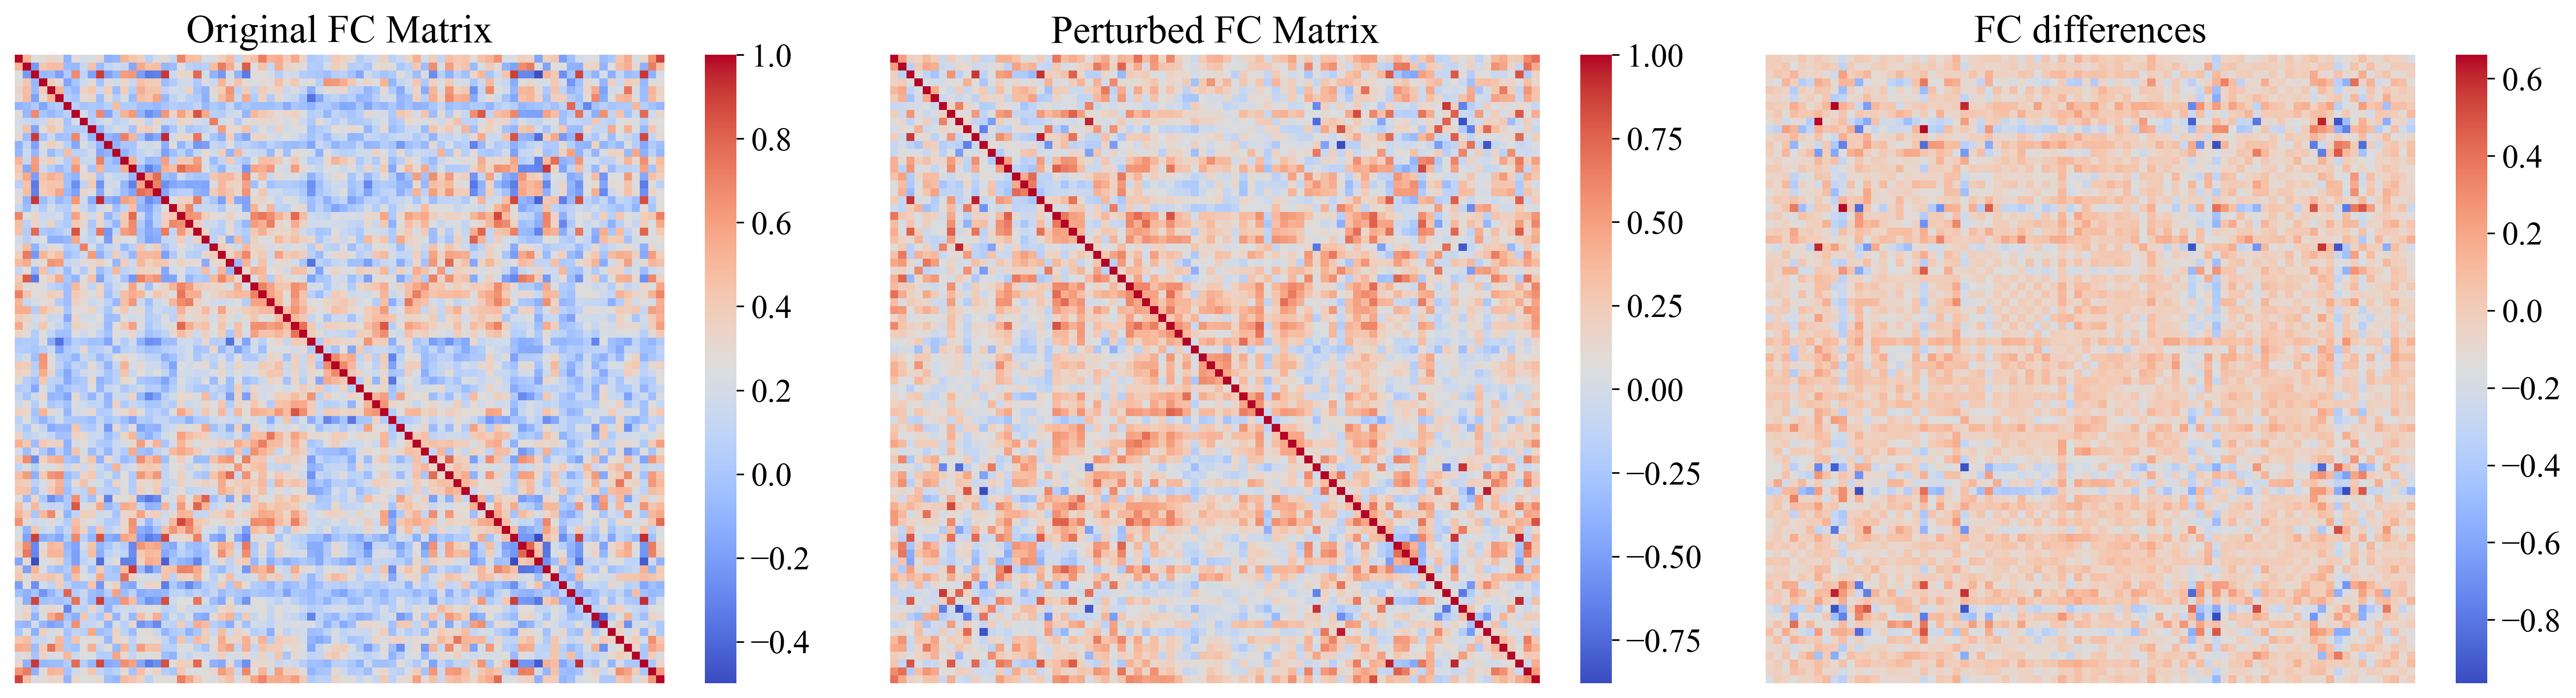

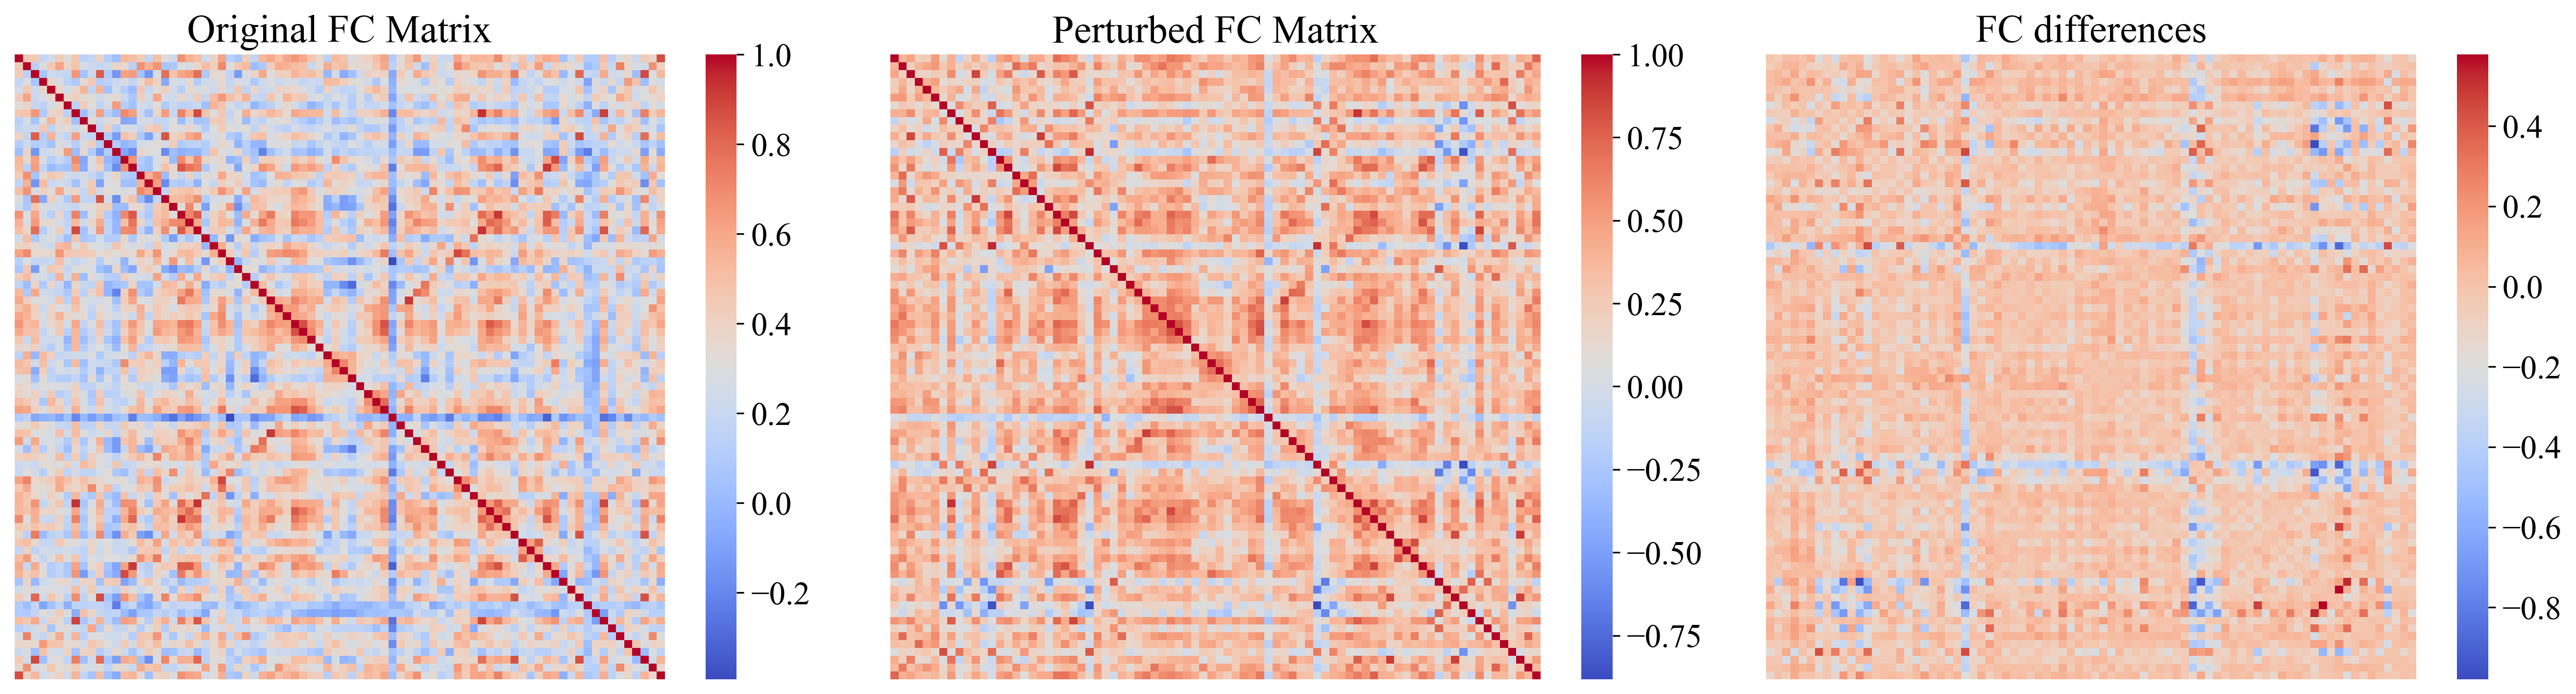

In [287]:
# perform best signal and region and plot FC matrices
regions = re.split(r'\+', best_region)
region_one = int(regions[0]) - 1
region_two = int(regions[1]) - 1

for participant in range(num_n3//4):
    sleeper = latent_n3_data[participant]
    perturbed_data = apply_perturbation_two_region(sleeper, best_signals[participant][0], region_one, best_signals[participant][1], region_two)
    decoded_data = model.decoder(perturbed_data.view(-1, latent_dimension))
    decoded_fc = compute_fc_matrix_regular(decoded_data.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
    decoded_original = model.decoder(sleeper.view(-1, latent_dimension))
    decoded_fc_original = compute_fc_matrix_regular(decoded_original.view(num_time_points, num_brain_nodes), num_brain_nodes=80)
    decoded_awake = model.decoder(latent_wake_data[participant].view(-1, latent_dimension))
    decoded_fc_awake = compute_fc_matrix_regular(decoded_awake.view(num_time_points, num_brain_nodes), num_brain_nodes=80)

    fc_diff = decoded_fc - decoded_fc_original

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(decoded_fc_original, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('Original FC Matrix')
    plt.subplot(1, 3, 2)
    sns.heatmap(decoded_fc, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('Perturbed FC Matrix')
    plt.subplot(1, 3, 3)
    sns.heatmap(fc_diff, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title('FC differences')
    # plt.subplot(1, 4, 4)
    # sns.heatmap(decoded_fc_awake, cmap="coolwarm", xticklabels=False, yticklabels=False)
    # plt.title('Awake FC Matrix')
    # plt.show()
    plt.tight_layout()

In [288]:
# Initialize probabilities matrix dimensions
num_regions = len(total_regions)
num_freqs = len(freqs)
probabilities = np.zeros((num_regions, num_freqs))

# Dictionary to map region names to their indices in probabilities array
region_index_map = {region: idx for idx, region in enumerate(total_regions)}

# Set to keep track of processed pairs
processed_pairs = set()

# Extract probabilities for each region and frequency combination
for key, regions in total_signals.items():
    # Extract regions from the key and sort them
    region_pair = tuple(sorted(re.findall(r'\d+', key)))

    # Check if the reverse pair has already been processed
    if region_pair in processed_pairs:
        continue

    # Add the current pair to the processed set
    processed_pairs.add(region_pair)

    for region, data in regions.items():
        region_number = region_index_map[region]
        frequency = re.findall(r'\d+', key)
        frequency = float('.'.join(frequency))

        # % of perturbed* states classified as W
        prob = sum(1 for p in data['Predictions'] if p[0] == 0) / num_n3 * 100

        # Store probability in the corresponding location
        probabilities[region_number, freqs.index(frequency)] = prob

In [289]:
# x_axis = freqs
# y_axis = list(total_regions.keys())

# plt.figure(figsize=(10, 100))
# sns.heatmap(probabilities, cmap="crest", xticklabels=x_axis, yticklabels=y_axis, annot=True, vmin=0, vmax=100)
# plt.title('% of perturbed * states classified as W')
# plt.xlabel('Signal frequency')
# plt.ylabel('Region pair')
# plt.yticks(rotation=45)
# plt.show()

In [290]:
# get all probabilities for best frequency
best_freq_idx = freqs.index(float(best_signal[1:]))
best_freq_probabilities = probabilities[:, best_freq_idx]

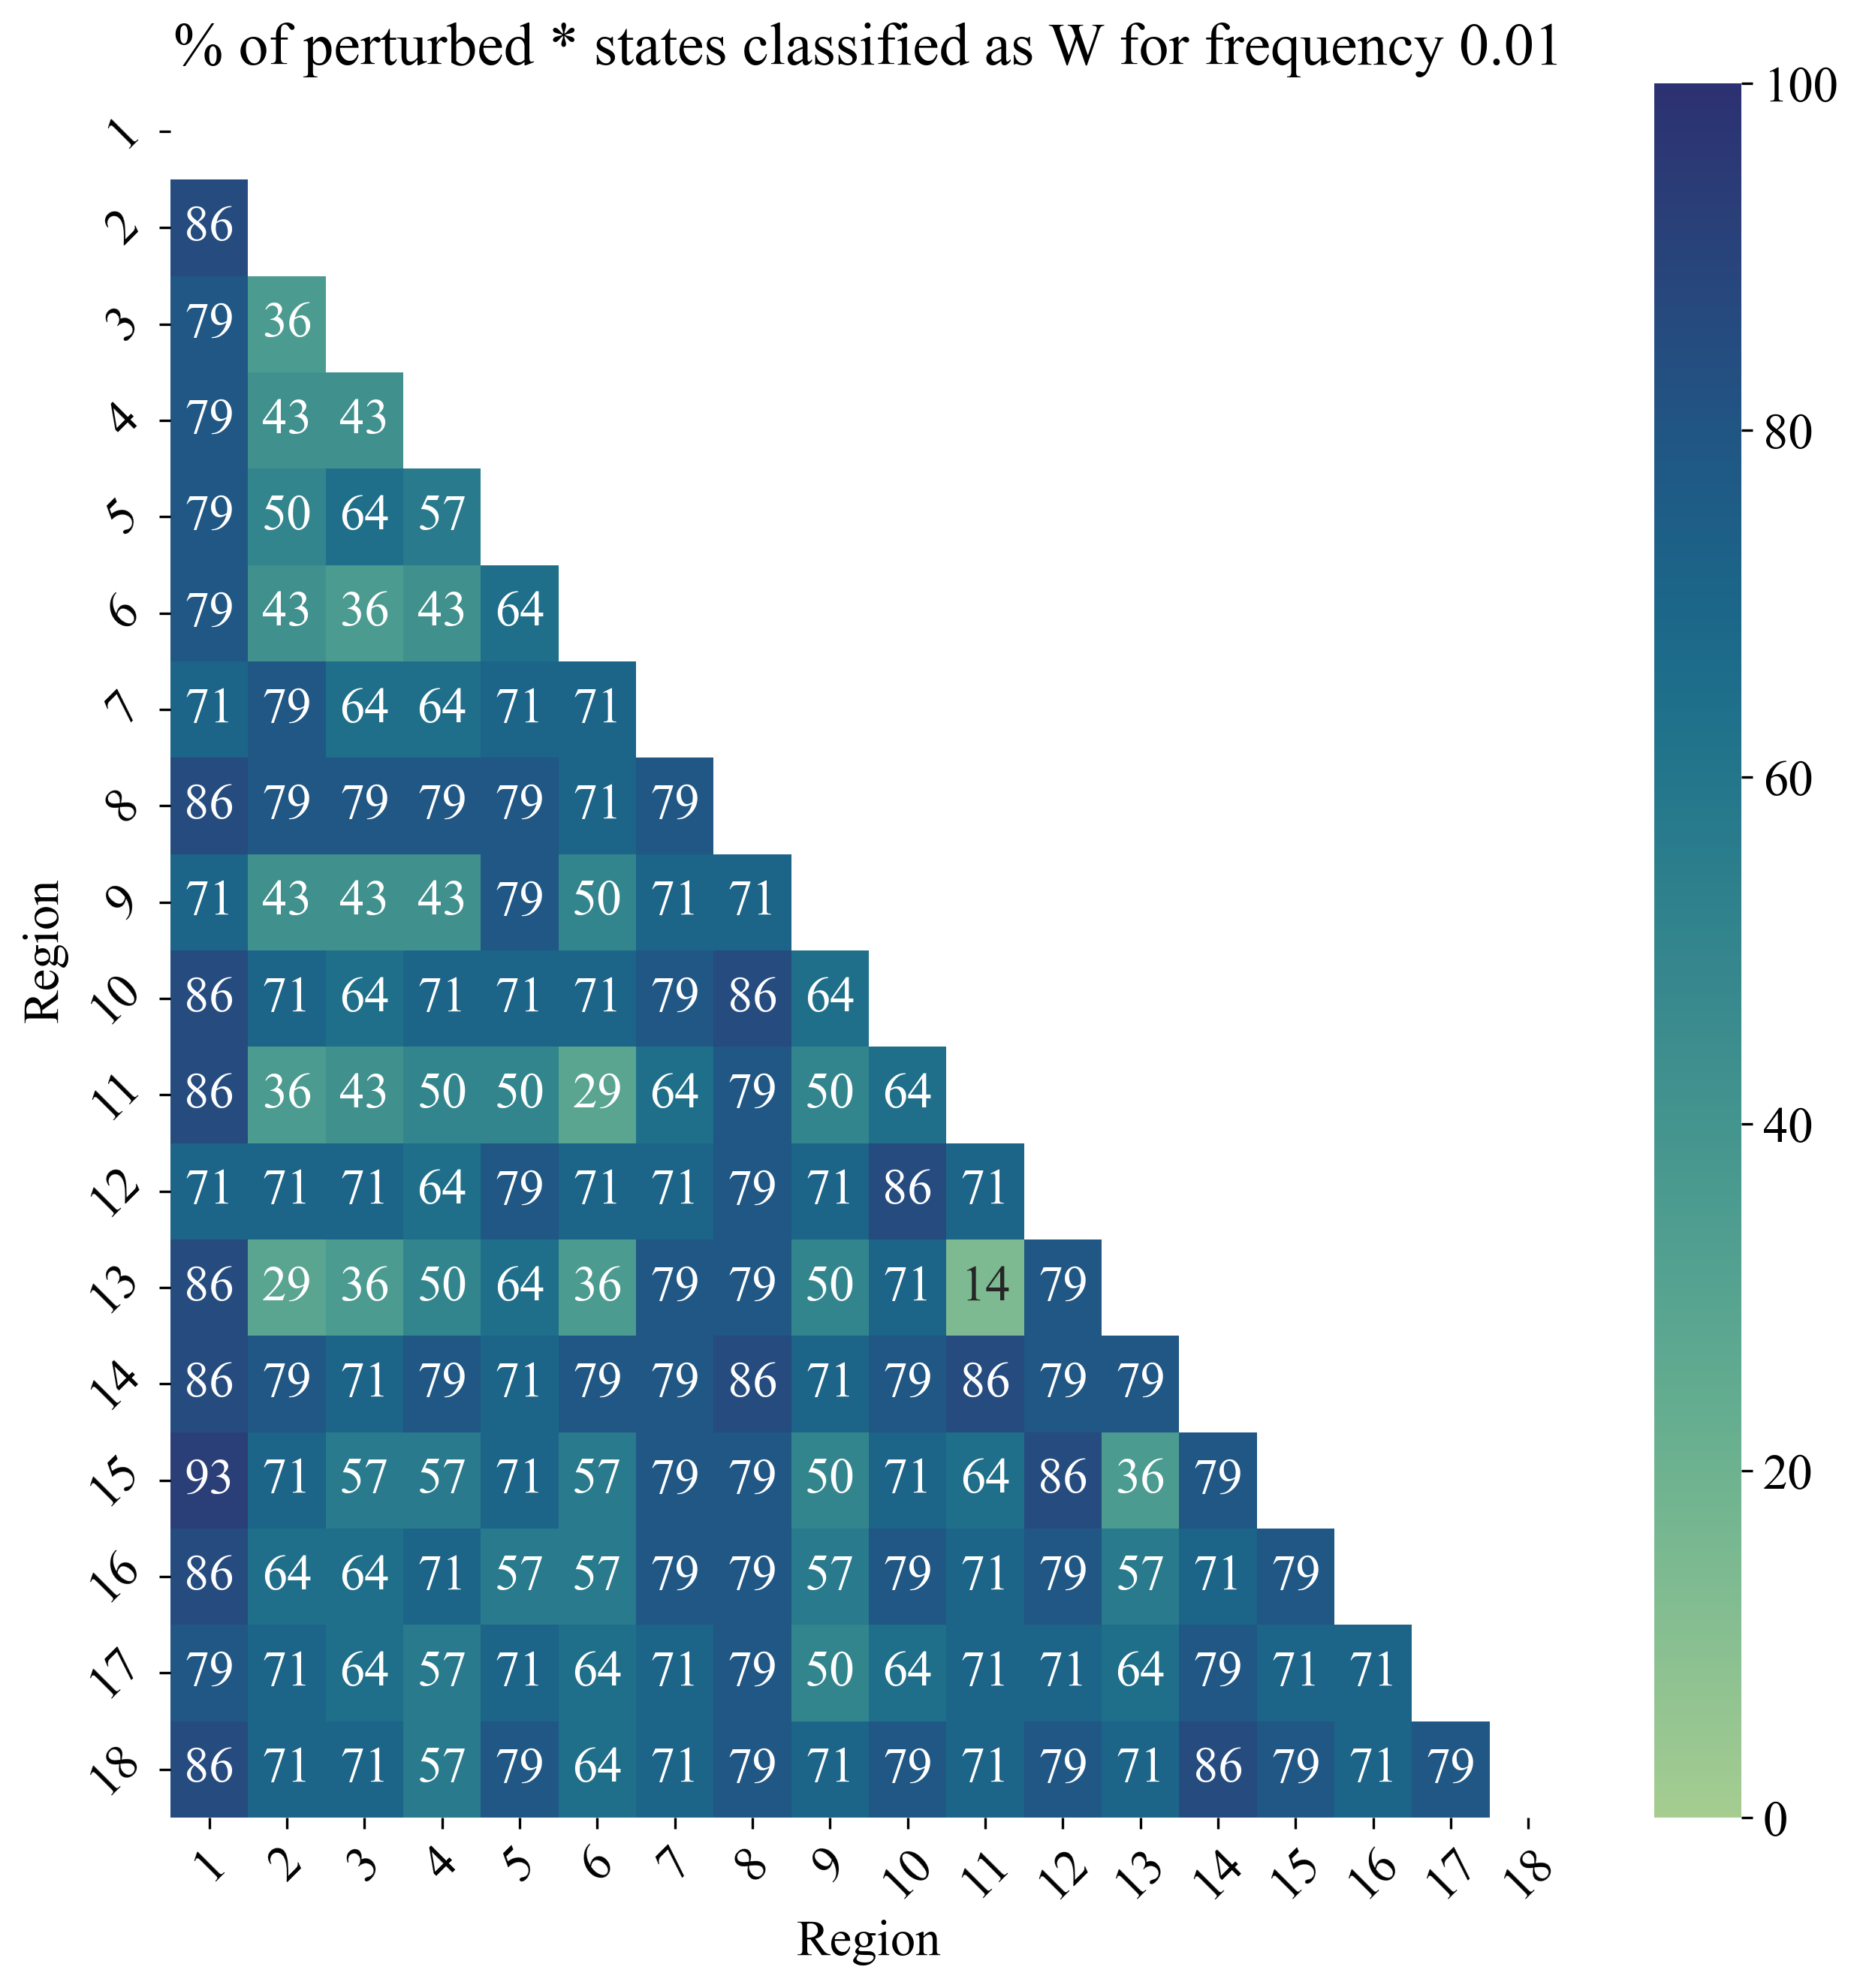

In [291]:
# split best frequency probabilities into region x region matrix
region_pairs = list(total_regions.keys())

region_pairs_matrix = np.zeros((latent_dimension, latent_dimension))

for idx, region_pair in enumerate(region_pairs):
    region_one, region_two = region_pair.split('+')
    region_one = int(region_one) - 1
    region_two = int(region_two) - 1
    region_pairs_matrix[region_two, region_one] = best_freq_probabilities[idx]

# upper triangle mask
mask = np.triu(np.ones_like(region_pairs_matrix, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(region_pairs_matrix, mask=mask, cmap="crest", xticklabels=np.arange(1, latent_dimension + 1), yticklabels=np.arange(1, latent_dimension + 1), annot=True, vmin=0, vmax=100)
plt.title(f'% of perturbed * states classified as W for frequency {best_signal[1:]}')
plt.xlabel('Region')
plt.ylabel('Region')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()